<a href="https://colab.research.google.com/github/Udzf/EV/blob/main/Copie_de_EV_quality_air.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.8 MB/s eta 0:00:00


In [2]:
!pip install pyjstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.0/798.0 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyjstat: filename=pyjstat-2.4.0-py3-none-any.whl size=22763 sha256=9f99ea732dfd9f755060c715bba0469cda3d016e72a0736ab42cb325be37f9fe
  Stored in directory: /root/.cache/pip/wheels/d7/b0/ac/350c026feabb6a22b2a5b3fb1f694e724c0f57c2c43ccaf738
Successfully built pyjstat


In [3]:
import requests
import json
from pyjstat import pyjstat
import pandas as pd
import io

# Data Presentation




## Percentage of EV in Switzerland

In [4]:
# API URL
url = "https://www.pxweb.bfs.admin.ch/api/v1/en/px-x-1103020100_101/px-x-1103020100_101.px"

# JSON query body
query = {
    "query": [
        {
            "code": "Kanton",
            "selection": {
                "filter": "item",
                "values": ["0"]
            }
        },
        {
            "code": "Treibstoff",
            "selection": {
                "filter": "item",
                "values": ["100", "200", "300", "9900", "9999"]
            }
        }
    ],
    "response": {
        "format": "json-stat"
    }
}

# Send POST request
headers = {
    "Content-Type": "application/json"
}

response = requests.post(url, headers=headers, data=json.dumps(query))

# Handle the response
if response.status_code == 200:
    result = response.json()

    # Parse JSON-stat to DataFrame
    dataset = pyjstat.Dataset.read(json.dumps(result))
    df = dataset.write('dataframe')

In [5]:
# Create a list of the desired values
desired_values = ["> Passenger cars", "> Passenger vehicles", "> Goods vehicles", "> Agricultural vehicles", "> Industrial vehicles", "> Motorcycles"]

# Filter the DataFrame
filtered_df = df[df['Vehicle group / type'].isin(desired_values)]

# Update the original DataFrame
df = filtered_df

In [6]:
filtered_df = df[(df['Fuel'] == 'Without motor') & (df['value'] > 0)]
vehicle_groups = filtered_df['Vehicle group / type'].unique().tolist()



In [7]:
# Get the unique values from vehicle_groups
vehicle_groups_unique = set(vehicle_groups)

# Filter the DataFrame to exclude rows in vehicle_groups_unique
filtered_df = df[~df['Vehicle group / type'].isin(vehicle_groups_unique)]

# Update the original DataFrame
df = filtered_df

In [8]:
# Filter the DataFrame to exclude rows where Fuel is "Without motor"
filtered_df = df[df['Fuel'] != 'Without motor']

# Update the original DataFrame
df = filtered_df

In [9]:
electricity_sums_by_year = df[df['Fuel'] == 'Electricity'].groupby('Year')['value'].sum() / df.groupby('Year')['value'].sum()

# Convert the result to a DataFrame
electricity_sums_by_year = electricity_sums_by_year.to_frame(name='% of EV')



In [10]:
# Assuming electricity_sums_by_year is your DataFrame
electricity_sums_by_year = electricity_sums_by_year.rename(columns={'Year': 'Year'})  # Renaming the existing index to 'Year'

electricity_sums_by_year = electricity_sums_by_year.reset_index()  # Resetting the index to make 'Year' a regular column

In [11]:
import pandas as pd

# Assuming 'electricity_sums_by_year' is your DataFrame

# Set display option for floats
pd.set_option('display.float_format', '{:.10f}'.format)



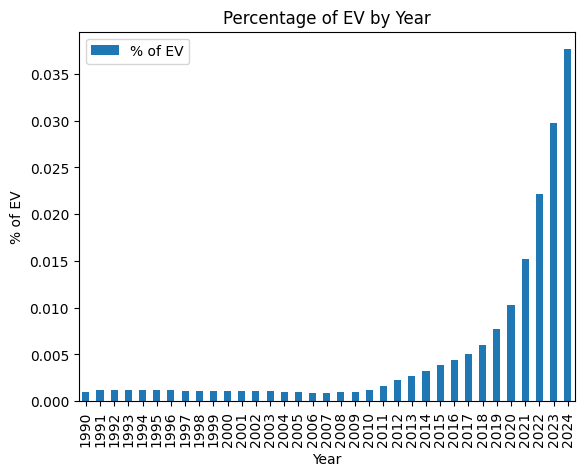

In [12]:
import matplotlib.pyplot as plt

# Assuming electricity_sums_by_year is your DataFrame
electricity_sums_by_year.plot(x='Year', y='% of EV', kind='bar')
plt.xlabel('Year')
plt.ylabel('% of EV')
plt.title('Percentage of EV by Year')
plt.show()

In [13]:
# Reset the index to make 'Fuel' and 'Year' regular columns
df_grouped = df.reset_index()

# Select the desired columns
df_grouped = df_grouped[['Fuel', 'Year', 'Canton', 'Vehicle group / type', 'value']]

# Optional: Sort the DataFrame by 'Fuel' and 'Year'
df_grouped = df_grouped.sort_values(by=['Fuel', 'Year'])



In [14]:
# Reset the index to make 'Fuel' and 'Year' regular columns
df_grouped = df.reset_index()

# Select the desired columns with 'Year' first
df_grouped = df_grouped[['Year', 'Fuel', 'Canton', 'Vehicle group / type', 'value']]

# Optional: Sort the DataFrame by 'Fuel' and 'Year'
df_grouped = df_grouped.sort_values(by=['Fuel', 'Year'])



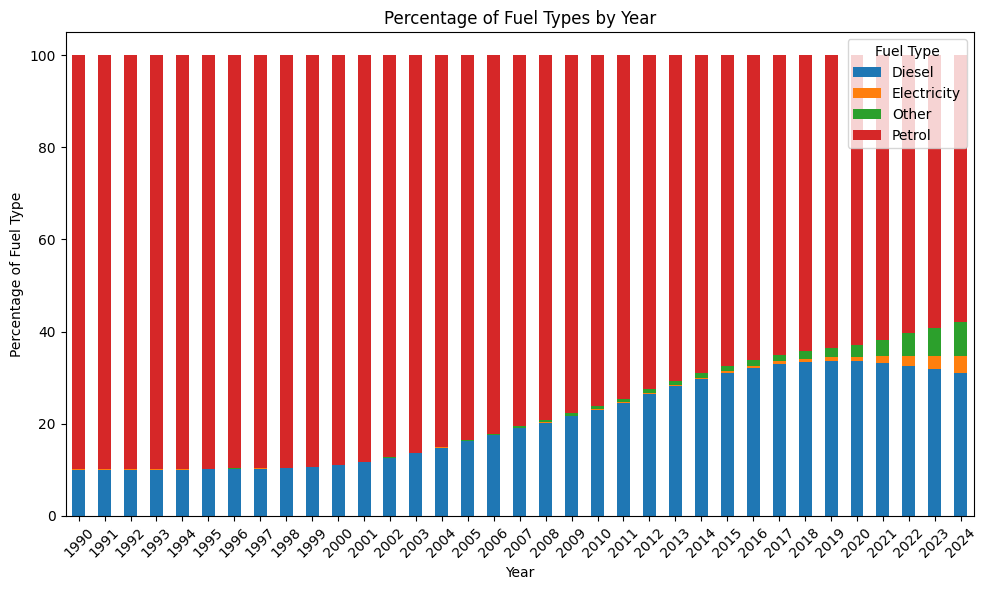

In [15]:
import matplotlib.pyplot as plt

# Group by 'Year' and 'Fuel' and calculate the sum of 'Value'
fuel_year_sums = df_grouped.groupby(['Year', 'Fuel'])['value'].sum().reset_index()

# Calculate the total sum of 'Value' for each year
year_totals = fuel_year_sums.groupby('Year')['value'].sum().reset_index()

# Merge the two DataFrames to calculate the percentage
fuel_year_sums = pd.merge(fuel_year_sums, year_totals, on='Year', suffixes=('', '_total'))
fuel_year_sums['Percentage'] = (fuel_year_sums['value'] / fuel_year_sums['value_total']) * 100

# Pivot the DataFrame to have 'Fuel' as columns and 'Percentage' as values
fuel_percentage_by_year = fuel_year_sums.pivot(index='Year', columns='Fuel', values='Percentage')

# Create the plot
fuel_percentage_by_year.plot(kind='bar', stacked=True, figsize=(10, 6))  # Adjust figsize as needed
plt.xlabel('Year')
plt.ylabel('Percentage of Fuel Type')
plt.title('Percentage of Fuel Types by Year')
plt.legend(title='Fuel Type')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [16]:
percentage_electricity_2024 = fuel_percentage_by_year.loc[fuel_percentage_by_year.index == '2024', 'Electricity'].values[0]
print(f"Percentage of Electricity in 2024: {percentage_electricity_2024:.2f}%")

Percentage of Electricity in 2024: 3.76%


## Percentage of EV per Canton

In [17]:

# API URL
url = "https://www.pxweb.bfs.admin.ch/api/v1/en/px-x-1103020100_101/px-x-1103020100_101.px"

# JSON query body
query = {

  "query": [
    {
      "code": "Kanton",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2",
          "3",
          "4",
          "5",
          "6",
          "7",
          "8",
          "9",
          "10",
          "11",
          "12",
          "13",
          "14",
          "15",
          "16",
          "17",
          "18",
          "19",
          "20",
          "21",
          "22",
          "23",
          "24",
          "25",
          "26"
        ]
      }
    },
    {
      "code": "Fahrzeuggruppe / -art",
      "selection": {
        "filter": "item",
        "values": [
          "100",
          "200",
          "300",
          "400",
          "500",
          "600"
        ]
      }
    },
    {
      "code": "Treibstoff",
      "selection": {
        "filter": "item",
        "values": [
          "100",
          "200",
          "300",
          "9900"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat"
  }
}

response = requests.post(url, headers=headers, data=json.dumps(query))

# Handle the response
if response.status_code == 200:
    result = response.json()

    # Parse JSON-stat to DataFrame
    dataset = pyjstat.Dataset.read(json.dumps(result))
    Canton_data = dataset.write('dataframe')


In [18]:
# Group by 'Canton', 'Year', and 'Fuel' and calculate the sum of 'Value'
canton_year_fuel_sums = Canton_data.groupby(['Canton', 'Year', 'Fuel'])['value'].sum().reset_index()

# Calculate the total sum of 'Value' for each Canton and year
canton_year_totals = canton_year_fuel_sums.groupby(['Canton', 'Year'])['value'].sum().reset_index()

# Merge the two DataFrames to calculate the percentage
canton_year_fuel_sums = pd.merge(canton_year_fuel_sums, canton_year_totals, on=['Canton', 'Year'], suffixes=('', '_total'))
canton_year_fuel_sums['Percentage'] = (canton_year_fuel_sums['value'] / canton_year_fuel_sums['value_total']) * 100

# Filter for 'Electricity' fuel type
electricity_percentage_by_canton_year = canton_year_fuel_sums[canton_year_fuel_sums['Fuel'] == 'Electricity']


In [19]:
# Find the canton with the highest percentage
highest_canton = electricity_percentage_by_canton_year.loc[electricity_percentage_by_canton_year['Percentage'].idxmax(), 'Canton']


# Find the canton with the lowest percentage
lowest_canton = electricity_percentage_by_canton_year.loc[electricity_percentage_by_canton_year['Percentage'].idxmin(), 'Canton']

print(f"Canton with the highest percentage: {highest_canton}")
print(f"Canton with the lowest percentage: {lowest_canton}")

Canton with the highest percentage: Zug
Canton with the lowest percentage: Appenzell-Innerrhoden


In [20]:
# Sort by Percentage in descending order, get the top 2 unique cantons, and convert to a list
highest_cantons = electricity_percentage_by_canton_year.sort_values(by='Percentage', ascending=False)['Canton'].unique()[:2].tolist()

# Sort by Percentage in ascending order, get the top 2 unique cantons, and convert to a list
lowest_cantons = electricity_percentage_by_canton_year.sort_values(by='Percentage', ascending=True)['Canton'].unique()[:2].tolist()

print(f"Cantons with the highest percentage: {highest_cantons}")
print(f"Cantons with the lowest percentage: {lowest_cantons}")

Cantons with the highest percentage: ['Zug', 'Zürich']
Cantons with the lowest percentage: ['Appenzell-Innerrhoden', 'Jura']


In [21]:
print(electricity_percentage_by_canton_year)

      Canton  Year         Fuel  value  value_total   Percentage
1     Aargau  1990  Electricity    156       288512 0.0540705413
5     Aargau  1991  Electricity    211       296981 0.0710483162
9     Aargau  1992  Electricity    224       302702 0.0740001718
13    Aargau  1993  Electricity    220       306964 0.0716696420
17    Aargau  1994  Electricity    207       314108 0.0659009003
...      ...   ...          ...    ...          ...          ...
3621  Zürich  2020  Electricity  12931       970446 1.3324801174
3625  Zürich  2021  Electricity  18987       984958 1.9276964094
3629  Zürich  2022  Electricity  27127       987608 2.7467375720
3633  Zürich  2023  Electricity  37277      1000235 3.7268241963
3637  Zürich  2024  Electricity  48156      1007599 4.7792822343

[910 rows x 6 columns]


In [22]:
electricity_percentage_by_canton_year['Year'] = pd.to_numeric(electricity_percentage_by_canton_year['Year'])
electricity_percentage_by_canton_year_2010 = electricity_percentage_by_canton_year[
    (electricity_percentage_by_canton_year['Year'] >= 2007) & (electricity_percentage_by_canton_year['Year'] <= 2022)
]

<ipython-input-22-539794d53d45>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electricity_percentage_by_canton_year['Year'] = pd.to_numeric(electricity_percentage_by_canton_year['Year'])


In [23]:
# Select the desired columns
electricity_percentage_by_year_by_canton = electricity_percentage_by_canton_year_2010[['Year', 'Canton', 'Percentage']]
print(electricity_percentage_by_year_by_canton)

      Year  Canton   Percentage
69    2007  Aargau 0.0404555922
73    2008  Aargau 0.0477964202
77    2009  Aargau 0.0560481828
81    2010  Aargau 0.0662913186
85    2011  Aargau 0.0736266312
...    ...     ...          ...
3613  2018  Zürich 0.7618764011
3617  2019  Zürich 0.9805270333
3621  2020  Zürich 1.3324801174
3625  2021  Zürich 1.9276964094
3629  2022  Zürich 2.7467375720

[416 rows x 3 columns]


In [24]:
# Group by 'Canton' and calculate the mean of 'Percentage'
average_percentage_by_canton = electricity_percentage_by_canton_year_2010.groupby('Canton')['Percentage'].mean()

# Convert the result to a DataFrame
average_percentage_by_canton = average_percentage_by_canton.to_frame(name='Average Percentage')

# Reset the index to make 'Canton' a regular column
average_percentage_by_canton = average_percentage_by_canton.reset_index()


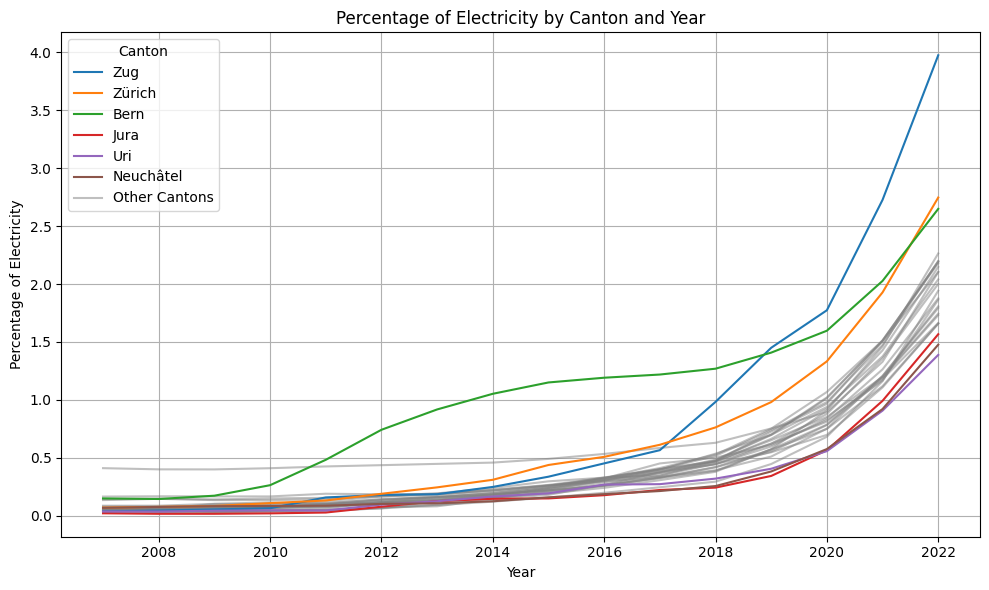

In [25]:
# Define the cantons to highlight in color
highlight_cantons = ["Zug", "Zürich", "Bern", "Jura", "Uri","Neuchâtel"]  # Updated highlight_cantons

# Pivot to create canton_percentage_by_year_2010
canton_percentage_by_year_2010 = electricity_percentage_by_canton_year_2010.pivot(
    index='Year', columns='Canton', values='Percentage'
)


# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed

# Plot all cantons in grey without adding them to the legend
for column in canton_percentage_by_year_2010.columns:
    if column not in highlight_cantons:
        canton_percentage_by_year_2010[column].plot(kind='line', ax=ax, color='grey', alpha=0.5)

# Plot highlighted cantons in color
for canton in highlight_cantons:
    if canton in canton_percentage_by_year_2010.columns:  # Check if canton is present in data
        canton_percentage_by_year_2010[canton].plot(kind='line', ax=ax, label=canton)

# Add a dummy line for "Other Cantons" to the legend
other_canton_line = ax.plot([], [], color='grey', alpha=0.5, label='Other Cantons')[0]  # Get the line object

# Get handles and labels for the legend
handles, labels = ax.get_legend_handles_labels()

# Filter handles and labels to keep only desired entries
desired_labels = highlight_cantons + ['Other Cantons']
desired_handles = [h for h, l in zip(handles, labels) if l in desired_labels]
desired_labels = [l for l in labels if l in desired_labels]  # Keep original order

# Create the legend with filtered handles and labels
plt.legend(desired_handles, desired_labels, title='Canton')

plt.xlabel('Year')
plt.ylabel('Percentage of Electricity')
plt.title('Percentage of Electricity by Canton and Year')
plt.grid(True)  # Add grid for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [26]:
# Filter for the year 2024
data_2024 = electricity_percentage_by_canton_year_2010[electricity_percentage_by_canton_year_2010['Year'] == 2024]

# Sort by Percentage in ascending order and get the top 2 unique cantons
lowest_cantons_2024 = data_2024.sort_values(by='Percentage', ascending=True)['Canton'].unique()[:2].tolist()

print(f"Cantons with the highest percentage of EVs in 2024: Zug, Zürich, Bern")
print(f"Cantons with the lowest percentage of EVs in 2024: Uri, Neuchâtel, Jura")

Cantons with the highest percentage of EVs in 2024: Zug, Zürich, Bern
Cantons with the lowest percentage of EVs in 2024: Uri, Neuchâtel, Jura


## Air quality in Switzerland

In [27]:
url = "https://raw.githubusercontent.com/Udzf/EV/main/emissions_data.csv"  # Direct link to raw content
response = requests.get(url)
data = response.content.decode('utf-8')  # Decode content to string
emissions_data = pd.read_csv(io.StringIO(data))

In [28]:
filtered_emissions_data = emissions_data[emissions_data['year'] >= 2000]

In [29]:
filtered_emissions_data2 = filtered_emissions_data[filtered_emissions_data['year'] != 2023]

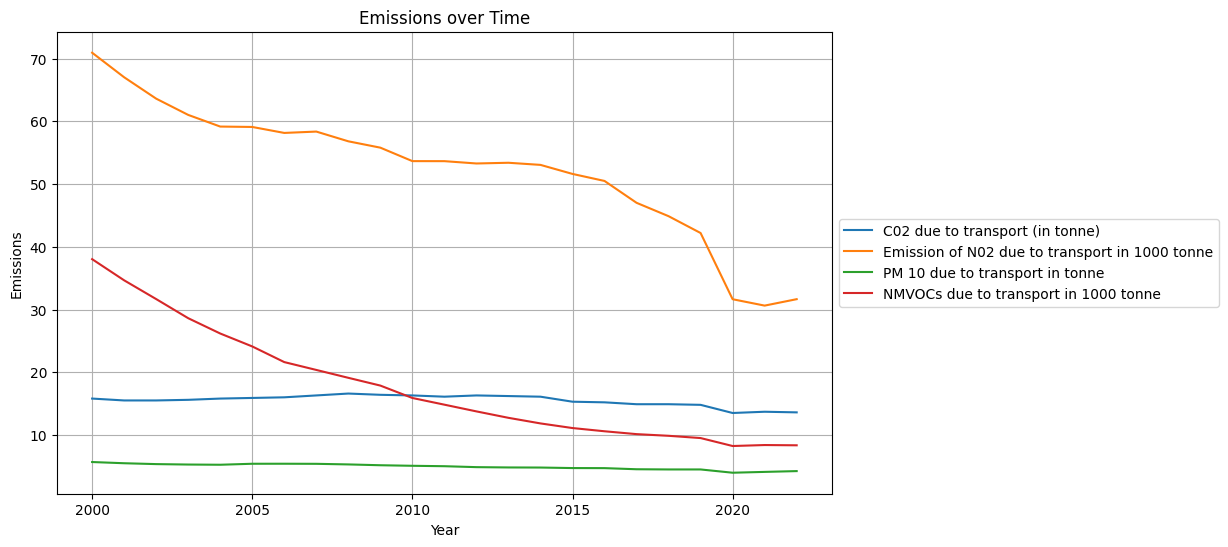

In [30]:
import matplotlib.pyplot as plt

# Assuming 'filtered_emissions_data2' is your DataFrame

# Set 'year' as the index for easier plotting
filtered_emissions_data2 = filtered_emissions_data2.set_index('year')

# Plot all columns except 'year'
filtered_emissions_data2.plot(figsize=(10, 6))  # Adjust figsize as needed

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Emissions')  # You might need to adjust the label based on your data
plt.title('Emissions over Time')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Place legend outside the plot
plt.show()

In [31]:
filtered_emissions_data2 = filtered_emissions_data2.rename(columns={'year': 'Year'})

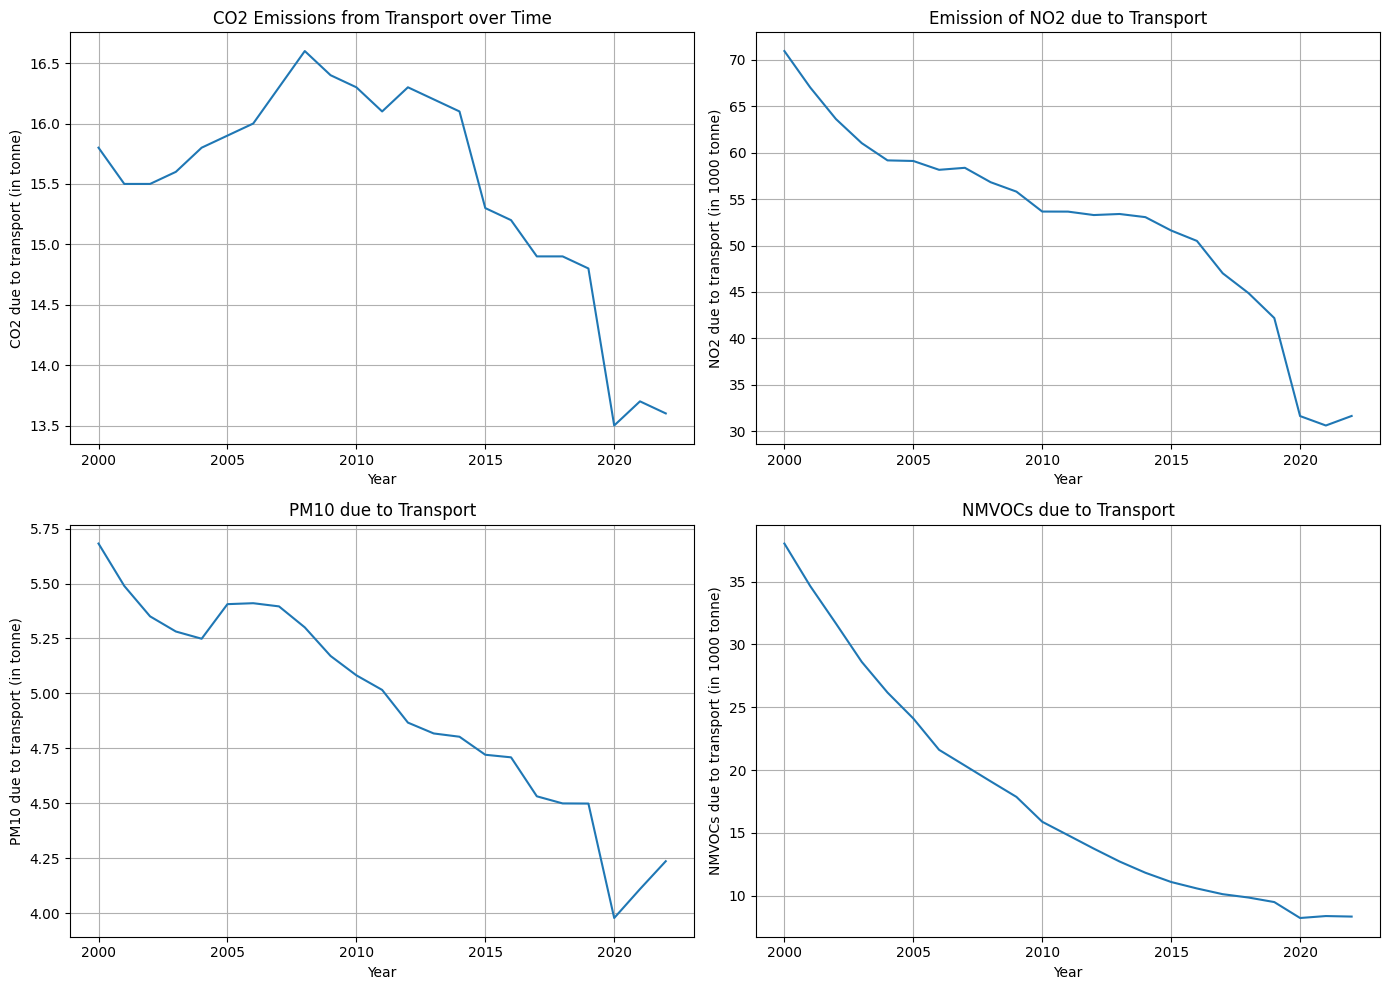

In [32]:
import matplotlib.pyplot as plt

# Assuming 'filtered_emissions_data2' is your DataFrame

# Set 'year' as the index (only once)
if 'year' in filtered_emissions_data2.columns:
    filtered_emissions_data2 = filtered_emissions_data2.set_index('year')

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# First plot - CO2 emissions
axes[0, 0].plot(filtered_emissions_data2.index, filtered_emissions_data2['C02 due to transport (in tonne)'])
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('CO2 due to transport (in tonne)')
axes[0, 0].set_title('CO2 Emissions from Transport over Time')
axes[0, 0].grid(True)

# Second plot - NO2 emissions
axes[0, 1].plot(filtered_emissions_data2.index, filtered_emissions_data2['Emission of N02 due to transport in 1000 tonne'])
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('NO2 due to transport (in 1000 tonne)')
axes[0, 1].set_title('Emission of NO2 due to Transport')
axes[0, 1].grid(True)

# Third plot - PM10 emissions
axes[1, 0].plot(filtered_emissions_data2.index, filtered_emissions_data2['PM 10 due to transport in tonne'])
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('PM10 due to transport (in tonne)')
axes[1, 0].set_title('PM10 due to Transport')
axes[1, 0].grid(True)

# Fourth plot - NMVOCs emissions
axes[1, 1].plot(filtered_emissions_data2.index, filtered_emissions_data2['NMVOCs due to transport in 1000 tonne'])
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('NMVOCs due to transport (in 1000 tonne)')
axes[1, 1].set_title('NMVOCs due to Transport')
axes[1, 1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [33]:
# Reset the index to make the index values a column
filtered_emissions_data2 = filtered_emissions_data2.reset_index()

# Rename the column that now contains the year information to 'year'
# After reset_index, the previous index is usually named 'index' or similar,
# but based on your output, it might be the first column.
# Let's verify the column names after reset_index and then rename.
print(filtered_emissions_data2.columns)

# Assuming the first column is now the 'year' column after reset_index
filtered_emissions_data2 = filtered_emissions_data2.rename(columns={filtered_emissions_data2.columns[0]: 'year'})



Index(['year', 'C02 due to transport (in tonne)',
       'Emission of N02 due to transport in 1000 tonne',
       'PM 10 due to transport in tonne',
       'NMVOCs due to transport in 1000 tonne'],
      dtype='object')


## Air quality per Canton

In [34]:
import requests
url = "https://raw.githubusercontent.com/Udzf/EV/main/air_quality_per_canton.csv"  # Raw content URL for CSV file
response = requests.get(url)
data = response.content.decode('utf-8')  # Decode content using UTF-8
air_quality_per_canton = pd.read_csv(io.StringIO(data))



In [35]:
# Merge the DataFrames on 'Year' and 'Canton'
merged_data3 = pd.merge(electricity_percentage_by_year_by_canton, air_quality_per_canton, on=['Year', 'Canton'], how='inner')



# Correlation between EV and air quality in Switzerland

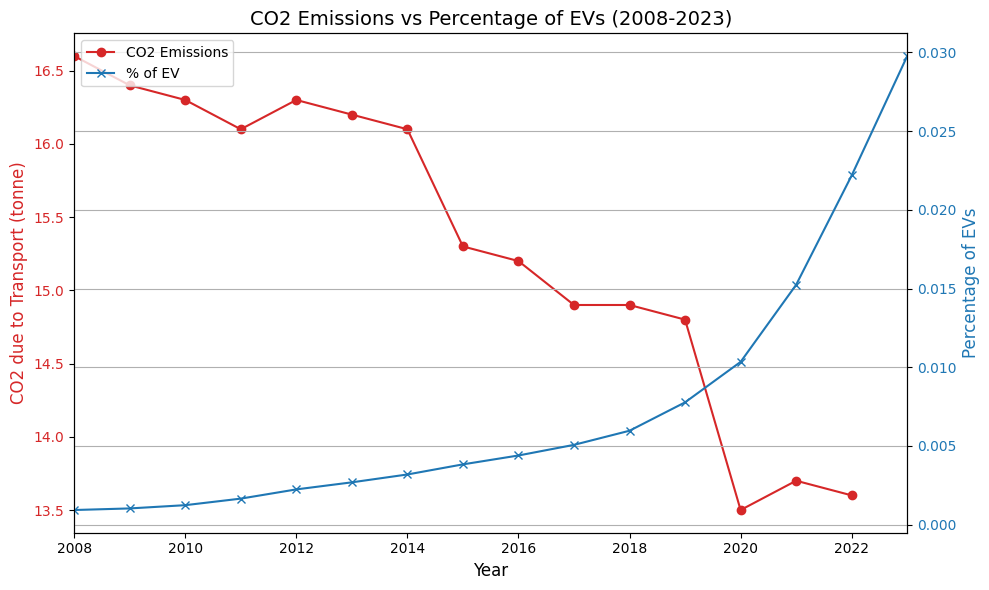

In [36]:
import matplotlib.pyplot as plt
import pandas as pd # Make sure pandas is imported

# Assuming filtered_emissions_data2 and electricity_sums_by_year are already loaded

# Convert 'Year' column to numeric type
electricity_sums_by_year['Year'] = pd.to_numeric(electricity_sums_by_year['Year'])

# Filter electricity_sums_by_year for the desired year range
electricity_sums_by_year_filtered = electricity_sums_by_year[
    (electricity_sums_by_year['Year'] >= 2008) & (electricity_sums_by_year['Year'] <= 2023)
]

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))  # Adjusted figsize for better readability

# Plot CO2 on primary Y-axis (2008-2023)
ax1.plot(filtered_emissions_data2['year'], filtered_emissions_data2['C02 due to transport (in tonne)'],
         color='tab:red', marker='o', label='CO2 Emissions')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('CO2 due to Transport (tonne)', color='tab:red', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create secondary Y-axis for % of EVs (2008-2023)
ax2 = ax1.twinx()
ax2.plot(electricity_sums_by_year_filtered['Year'], electricity_sums_by_year_filtered['% of EV'],
         color='tab:blue', marker='x', label='% of EV')
ax2.set_ylabel('Percentage of EVs', color='tab:blue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Set x-axis limits to 2008-2023
ax1.set_xlim(2008, 2023)

# Title and layout
plt.title('CO2 Emissions vs Percentage of EVs (2008-2023)', fontsize=14)
plt.grid(True)

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')  # Adjust legend location as needed

plt.tight_layout()
plt.show()

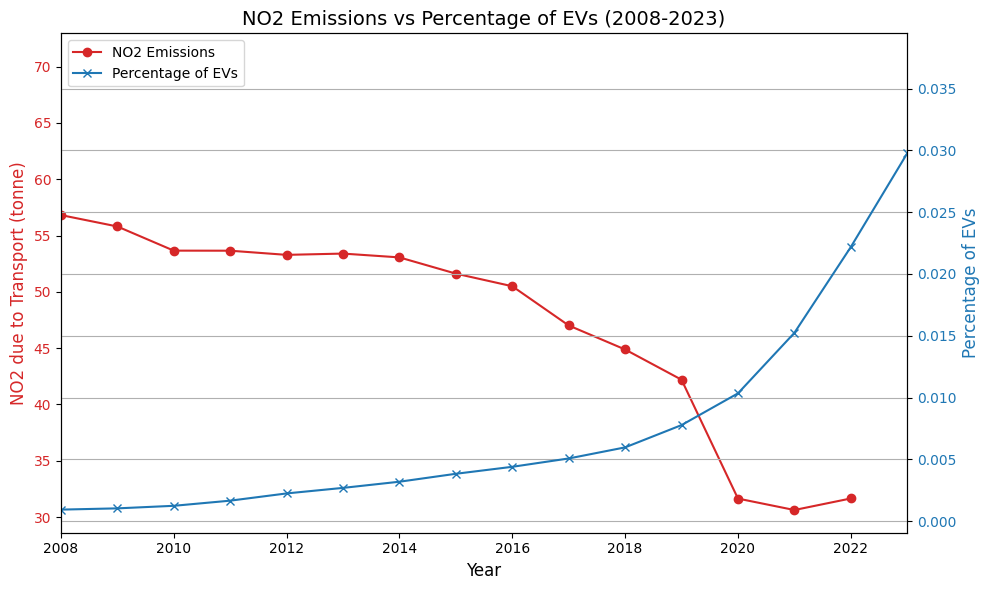

In [37]:
import matplotlib.pyplot as plt

# Assuming filtered_emissions_data2 and electricity_sums_by_year are already loaded

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))  # Adjusted figsize for better readability

# Plot CO2 on primary Y-axis (2000-2023)
ax1.plot(filtered_emissions_data2['year'], filtered_emissions_data2['Emission of N02 due to transport in 1000 tonne'],
         color='tab:red', marker='o', label='NO2 Emissions')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('NO2 due to Transport (tonne)', color='tab:red', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create secondary Y-axis for % of EVs (2000-2023)
ax2 = ax1.twinx()
ax2.plot(electricity_sums_by_year['Year'], electricity_sums_by_year['% of EV'],
         color='tab:blue', marker='x', label='Percentage of EVs')
ax2.set_ylabel('Percentage of EVs', color='tab:blue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Set x-axis limits to 2000-2023
ax1.set_xlim(2008, 2023)

# Title and layout
plt.title('NO2 Emissions vs Percentage of EVs (2008-2023)', fontsize=14)
plt.grid(True)

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')  # Adjust legend location as needed

plt.tight_layout()
plt.show()

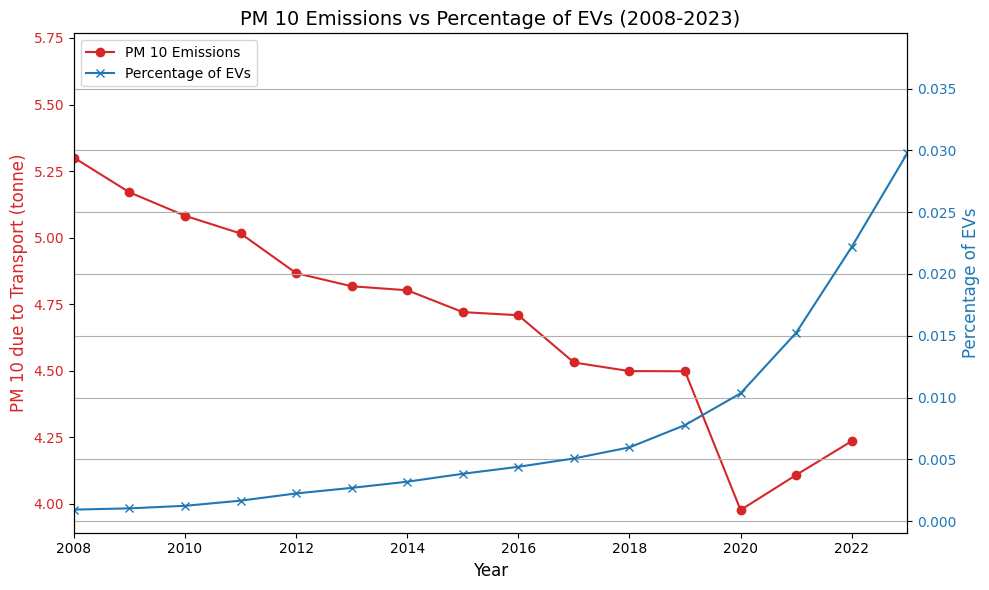

In [38]:
import matplotlib.pyplot as plt

# Assuming filtered_emissions_data2 and electricity_sums_by_year are already loaded

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))  # Adjusted figsize for better readability

# Plot CO2 on primary Y-axis (2000-2023)
ax1.plot(filtered_emissions_data2['year'], filtered_emissions_data2['PM 10 due to transport in tonne'],
         color='tab:red', marker='o', label='PM 10 Emissions')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('PM 10 due to Transport (tonne)', color='tab:red', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create secondary Y-axis for % of EVs (2000-2023)
ax2 = ax1.twinx()
ax2.plot(electricity_sums_by_year['Year'], electricity_sums_by_year['% of EV'],
         color='tab:blue', marker='x', label='Percentage of EVs')
ax2.set_ylabel('Percentage of EVs', color='tab:blue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Set x-axis limits to 2000-2023
ax1.set_xlim(2008, 2023)

# Title and layout
plt.title('PM 10 Emissions vs Percentage of EVs (2008-2023)', fontsize=14)
plt.grid(True)

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')  # Adjust legend location as needed

plt.tight_layout()
plt.show()

In [39]:
# Reset index if 'year' is the index in filtered_emissions_data2
if filtered_emissions_data2.index.name == 'year':
    filtered_emissions_data2 = filtered_emissions_data2.reset_index()

# Rename 'Year' to 'year' in electricity_sums_by_year
electricity_sums_by_year = electricity_sums_by_year.rename(columns={'Year': 'year'})

# Convert 'year' to int in both DataFrames
filtered_emissions_data2['year'] = filtered_emissions_data2['year'].astype(int)
electricity_sums_by_year['year'] = electricity_sums_by_year['year'].astype(int)

# Merge
merged_data = pd.merge(filtered_emissions_data2, electricity_sums_by_year, on='year', how='left')

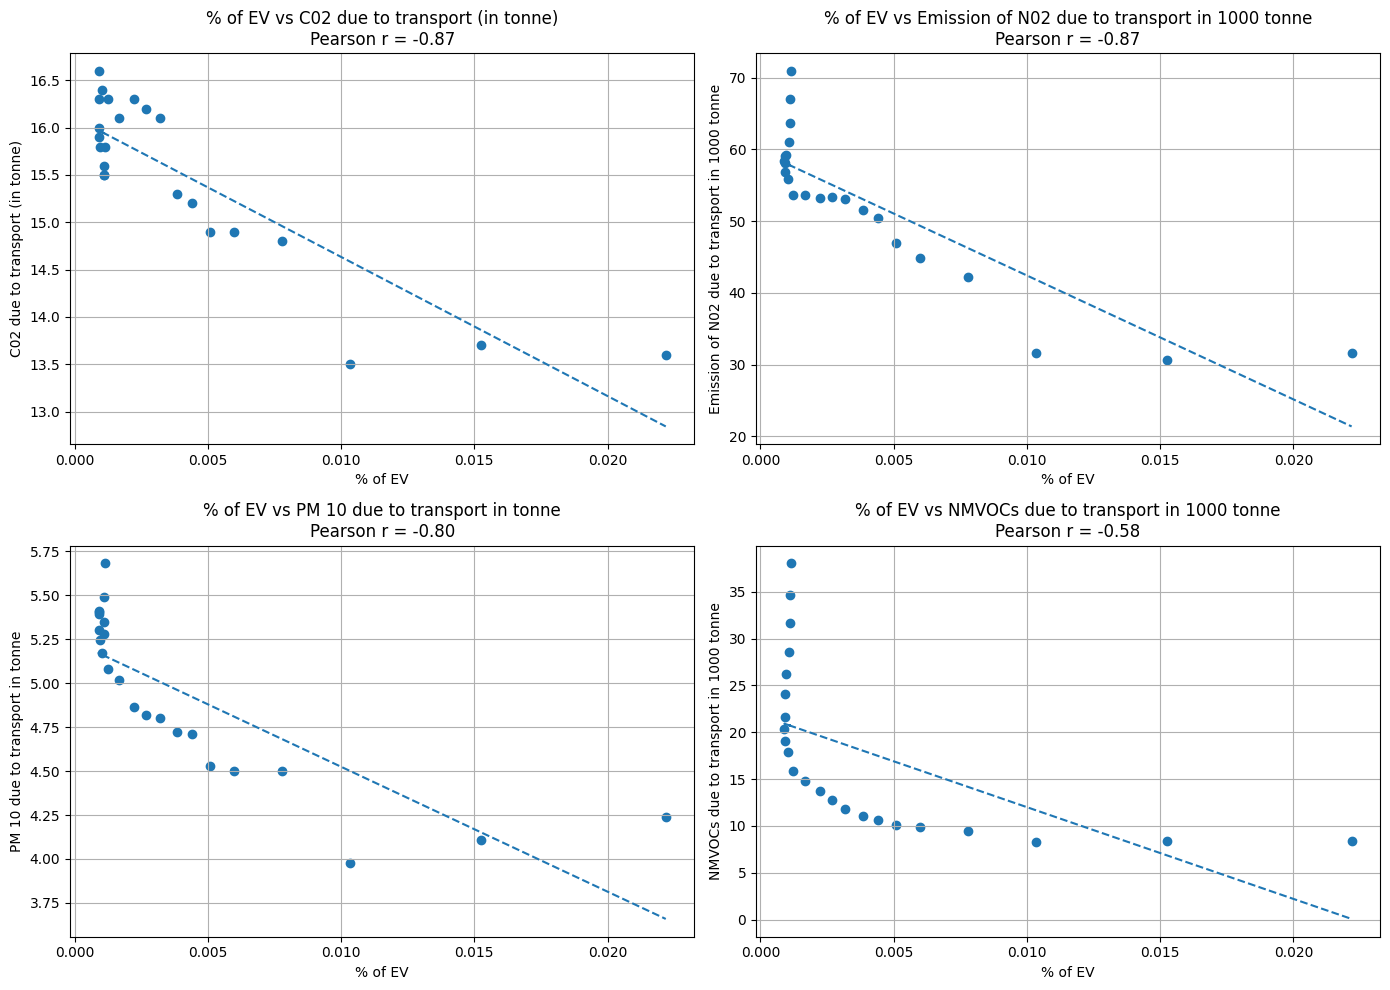

In [40]:
import matplotlib.pyplot as plt
import numpy as np  # <-- you need numpy for line fitting
from scipy.stats import pearsonr

# List of target emission columns
target_columns = [
    'C02 due to transport (in tonne)',
    'Emission of N02 due to transport in 1000 tonne',
    'PM 10 due to transport in tonne',
    'NMVOCs due to transport in 1000 tonne'
]

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Flatten axes for easier iteration
axes = axes.flatten()

# Loop over each target emission column
for idx, col in enumerate(target_columns):
    ax = axes[idx]
    x = merged_data['% of EV']
    y = merged_data[col]

    # Scatter plot
    ax.scatter(x, y)

    # Calculate Pearson correlation
    corr_coef, _ = pearsonr(x, y)

    # Fit and plot trend line
    m, b = np.polyfit(x, y, 1)  # 1 = linear
    ax.plot(x, m*x + b, linestyle='--')  # Dashed line for the trend

    # Plot title with correlation coefficient
    ax.set_title(f'% of EV vs {col}\nPearson r = {corr_coef:.2f}')
    ax.set_xlabel('% of EV')
    ax.set_ylabel(col)
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Features and target
X = merged_data[['% of EV']]  # Feature (independent variable)

targets = [
    'C02 due to transport (in tonne)',
    'Emission of N02 due to transport in 1000 tonne',
    'PM 10 due to transport in tonne',
    'NMVOCs due to transport in 1000 tonne'
]

for target in targets:
    y = merged_data[target]  # Target (dependent variable)

    # Initialize and fit model
    model = LinearRegression()
    model.fit(X, y)

    # Predictions
    y_pred = model.predict(X)

    # Evaluation
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    # Print results
    print(f"Predicting {target}:")
    print(f"   R² Score: {r2:.2f}")
    print(f"   RMSE: {rmse:.2f}")
    print()

Predicting C02 due to transport (in tonne):
   R² Score: 0.75
   RMSE: 0.44

Predicting Emission of N02 due to transport in 1000 tonne:
   R² Score: 0.75
   RMSE: 5.20

Predicting PM 10 due to transport in tonne:
   R² Score: 0.64
   RMSE: 0.28

Predicting NMVOCs due to transport in 1000 tonne:
   R² Score: 0.34
   RMSE: 7.17



Results for C02 due to transport (in tonne):
  Linear R^2: 0.752, RMSE: 0.440, Slope: -147.072
  Polynomial R^2: 0.832, RMSE: 0.362




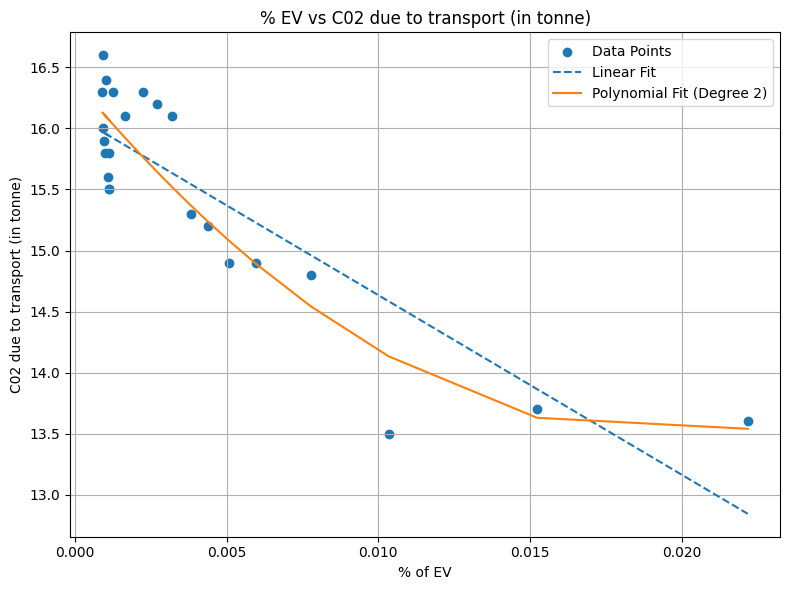

Results for Emission of N02 due to transport in 1000 tonne:
  Linear R^2: 0.750, RMSE: 5.201, Slope: -1727.510
  Polynomial R^2: 0.873, RMSE: 3.709




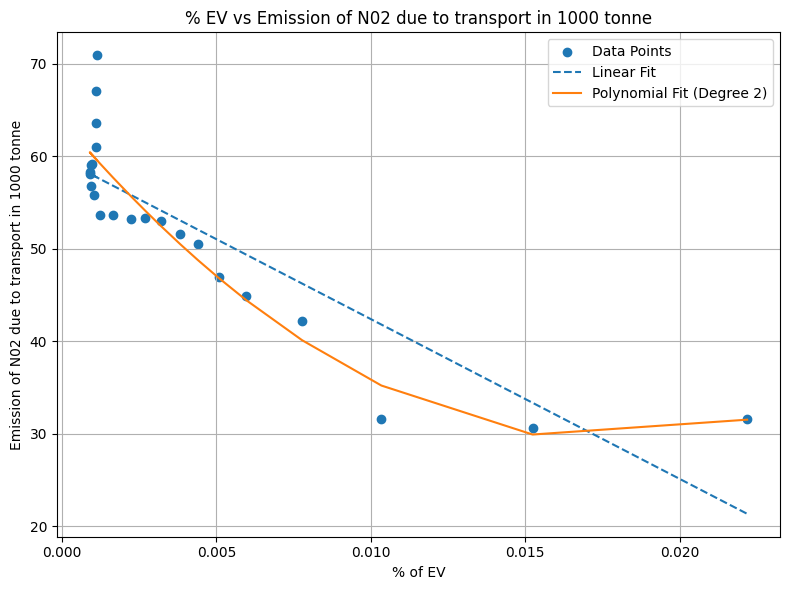

Results for PM 10 due to transport in tonne:
  Linear R^2: 0.644, RMSE: 0.275, Slope: -71.113
  Polynomial R^2: 0.899, RMSE: 0.146




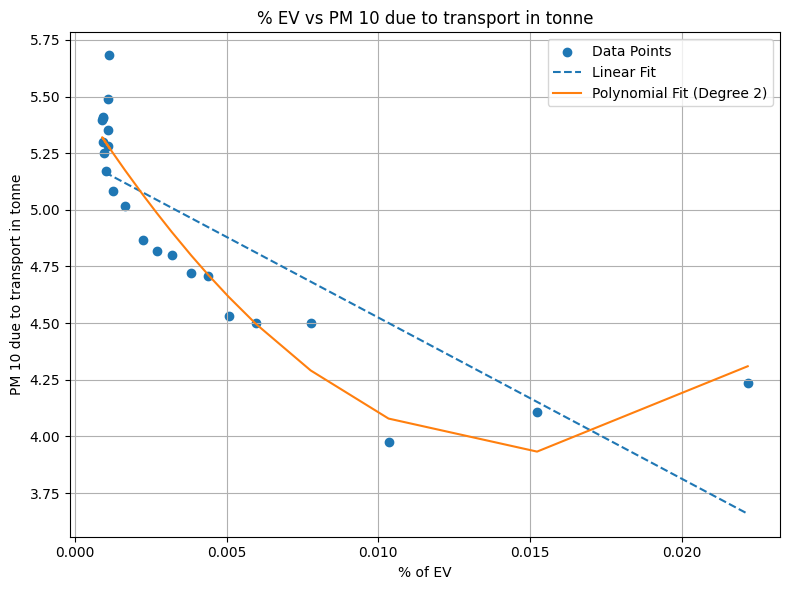

Results for NMVOCs due to transport in 1000 tonne:
  Linear R^2: 0.336, RMSE: 7.173, Slope: -979.551
  Polynomial R^2: 0.546, RMSE: 5.932




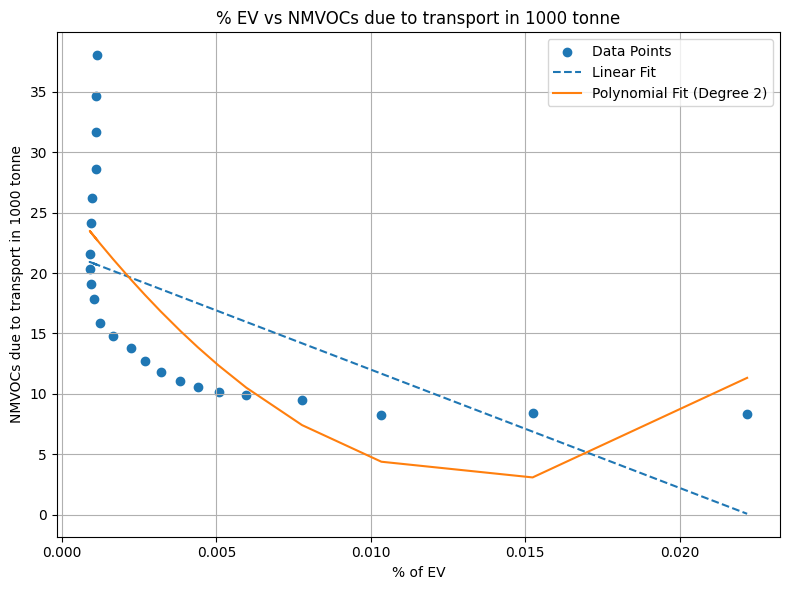

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# Define the pollutants you want to analyze
targets = [
    'C02 due to transport (in tonne)',
    'Emission of N02 due to transport in 1000 tonne',
    'PM 10 due to transport in tonne',
    'NMVOCs due to transport in 1000 tonne'
]

# Initialize PolynomialFeatures object
poly = PolynomialFeatures(degree=2)

# Define the function FIRST
def analyze_pollutants(data, feature='% of EV'):
    for target in targets:
        X = data[[feature]].values
        y = data[target].values

        # Linear Regression
        model_linear = LinearRegression()
        model_linear.fit(X, y)
        y_pred_linear = model_linear.predict(X)

        r2_linear = r2_score(y, y_pred_linear)
        rmse_linear = np.sqrt(mean_squared_error(y, y_pred_linear))

        # Polynomial Regression (degree 2)
        X_poly = poly.fit_transform(X)
        model_poly = LinearRegression()
        model_poly.fit(X_poly, y)
        y_pred_poly = model_poly.predict(X_poly)

        r2_poly = r2_score(y, y_pred_poly)
        rmse_poly = np.sqrt(mean_squared_error(y, y_pred_poly))

        # Print results
        print(f"Results for {target}:")
        print(f"  Linear R^2: {r2_linear:.3f}, RMSE: {rmse_linear:.3f}, Slope: {model_linear.coef_[0]:.3f}")
        print(f"  Polynomial R^2: {r2_poly:.3f}, RMSE: {rmse_poly:.3f}")
        print("\n")

        # Plot
        plt.figure(figsize=(8, 6))
        plt.scatter(X, y, label='Data Points')
        plt.plot(X, y_pred_linear, label='Linear Fit', linestyle='--')
        plt.plot(X, y_pred_poly, label='Polynomial Fit (Degree 2)', linestyle='-')
        plt.title(f'% EV vs {target}')
        plt.xlabel('% of EV')
        plt.ylabel(target)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ✅ NOW you call the function
analyze_pollutants(merged_data)

# Correlation between EV and air quality per canton

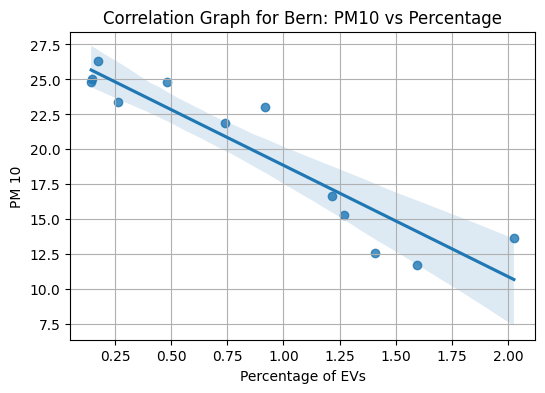

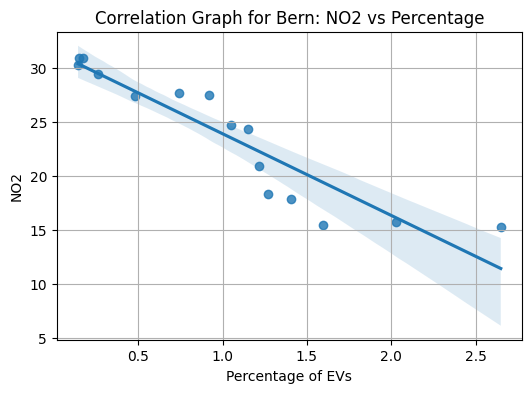

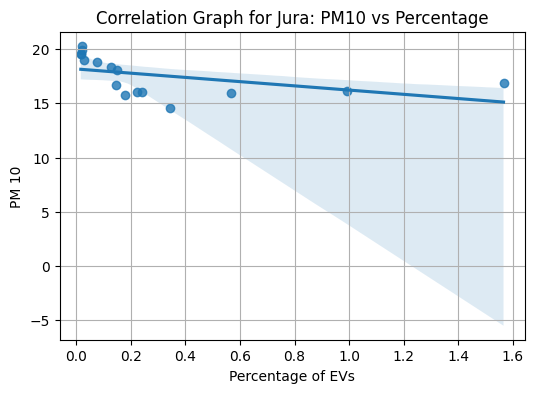

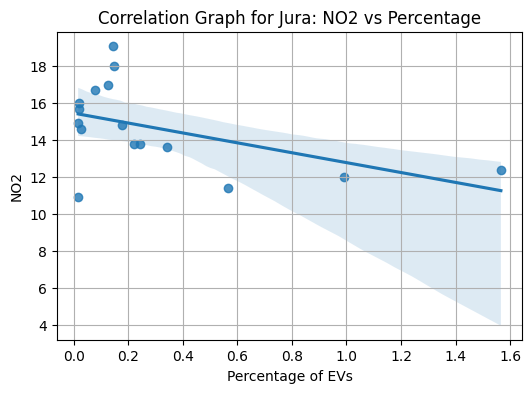

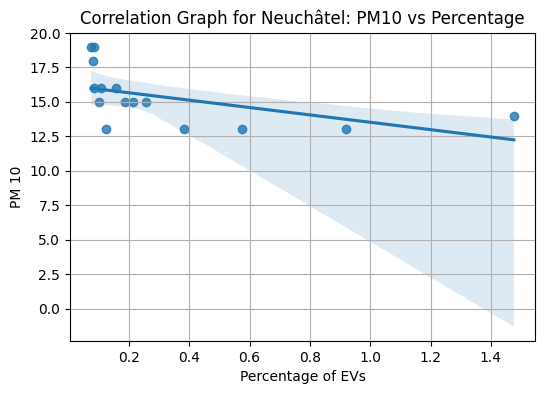

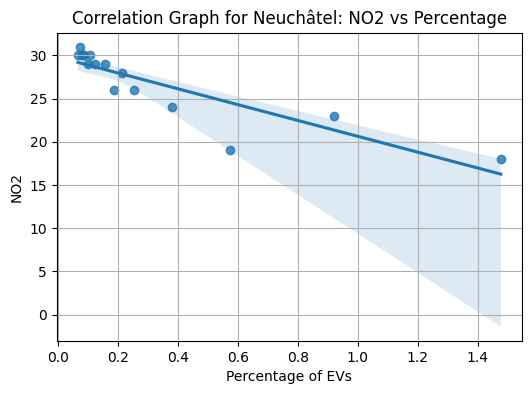

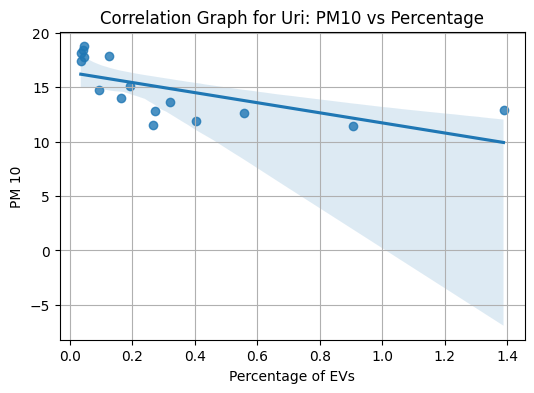

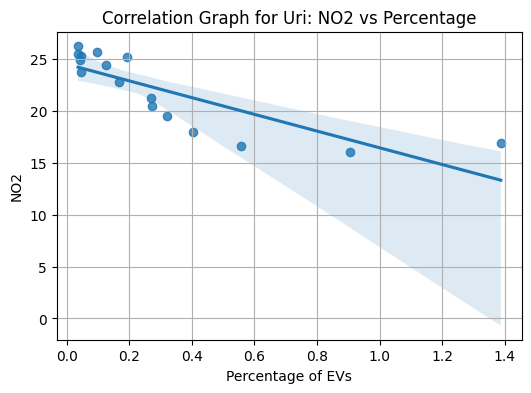

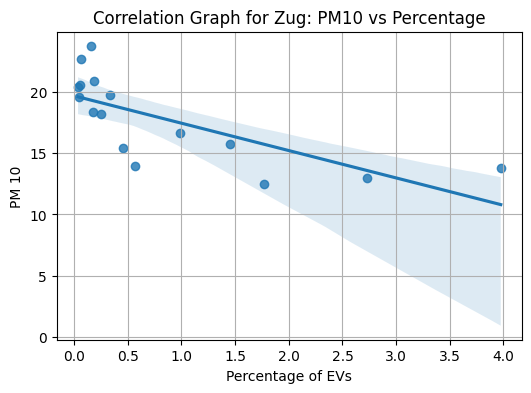

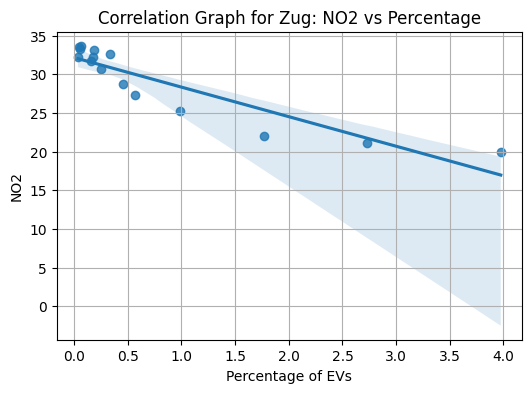

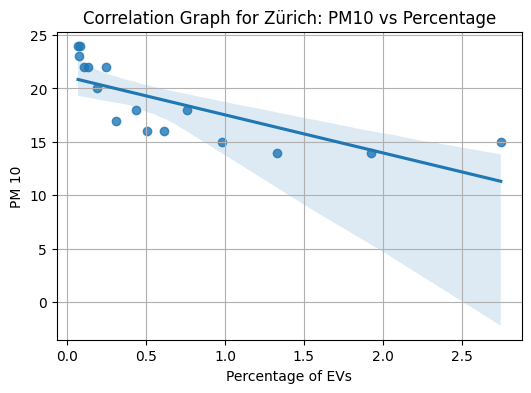

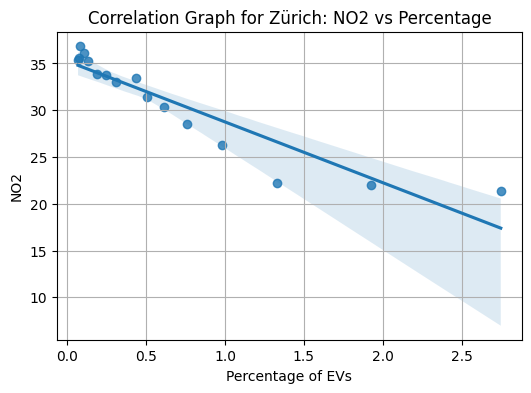

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group data by canton
grouped_data = merged_data3.groupby('Canton')

# Function to plot correlation graph
def plot_correlation_graph(data, pollutant, title):
    plt.figure(figsize=(6, 4))  # Adjust figsize as needed
    sns.regplot(x='Percentage', y=pollutant, data=data)  # Use regplot for scatter with trend line
    plt.title(title)
    plt.xlabel('Percentage of EVs')
    plt.ylabel(pollutant)
    plt.grid(True)
    plt.show()

# Iterate through cantons and plot graphs
for canton, data in grouped_data:
    plot_correlation_graph(data, 'PM 10', f'Correlation Graph for {canton}: PM10 vs Percentage')
    plot_correlation_graph(data, 'NO2', f'Correlation Graph for {canton}: NO2 vs Percentage')

# The Norway Case


In [44]:
url = "https://github.com/Udzf/EV/raw/main/Norway_data.csv"  # Direct link to raw content (updated URL)
response = requests.get(url)
data = response.content.decode('utf-8')  # Decode content using UTF-8
Norway_data = pd.read_csv(io.StringIO(data))



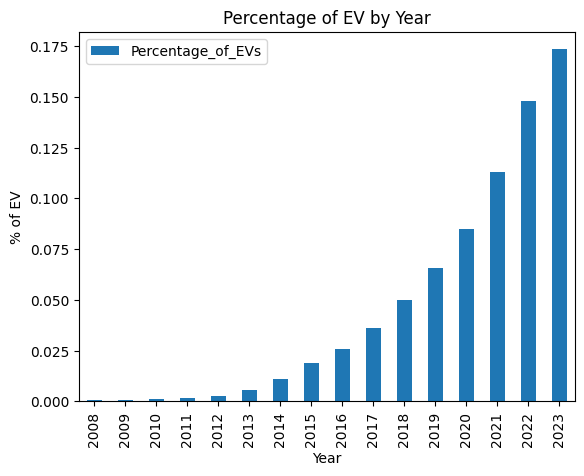

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

# Assuming electricity_sums_by_year is your DataFrame
Norway_data.plot(x='Year', y='Percentage_of_EVs', kind='bar')
plt.xlabel('Year')
plt.ylabel('% of EV')
plt.title('Percentage of EV by Year')
plt.show()


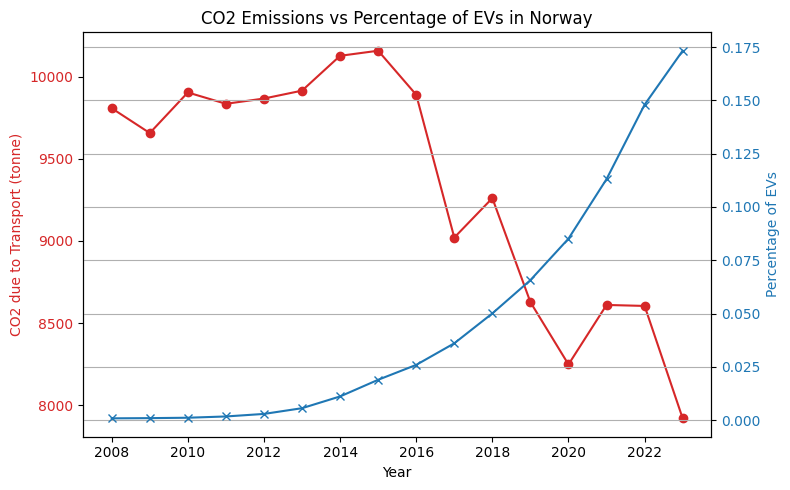

In [46]:
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot CO2 on primary Y-axis
ax1.plot(Norway_data['Year'], Norway_data['CO2_due_to_transport_(tonne)'], color='tab:red', marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('CO2 due to Transport (tonne)', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create secondary Y-axis for % of EVs
ax2 = ax1.twinx()
ax2.plot(Norway_data['Year'], Norway_data['Percentage_of_EVs'], color='tab:blue', marker='x')
ax2.set_ylabel('Percentage of EVs', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Title and layout
plt.title('CO2 Emissions vs Percentage of EVs in Norway')
plt.grid(True)
plt.tight_layout()
plt.show()

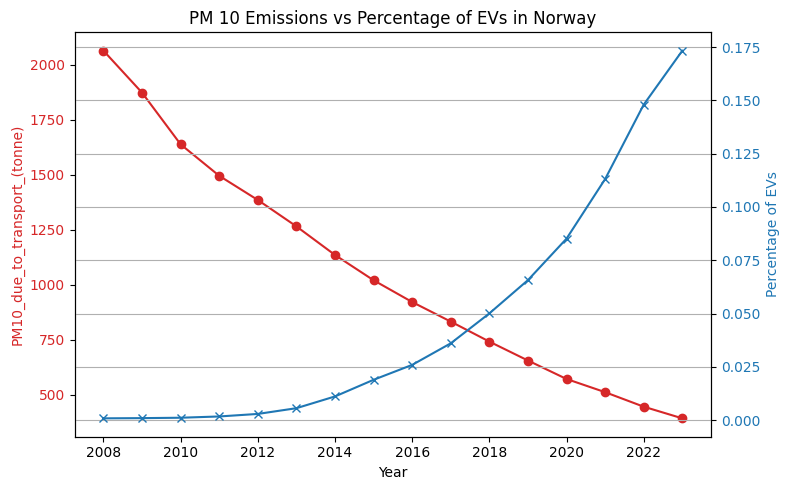

In [47]:
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot CO2 on primary Y-axis
ax1.plot(Norway_data['Year'], Norway_data['PM10_due_to_transport_(tonne)'], color='tab:red', marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('PM10_due_to_transport_(tonne)', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create secondary Y-axis for % of EVs
ax2 = ax1.twinx()
ax2.plot(Norway_data['Year'], Norway_data['Percentage_of_EVs'], color='tab:blue', marker='x')
ax2.set_ylabel('Percentage of EVs', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Title and layout
plt.title('PM 10 Emissions vs Percentage of EVs in Norway')
plt.grid(True)
plt.tight_layout()
plt.show()

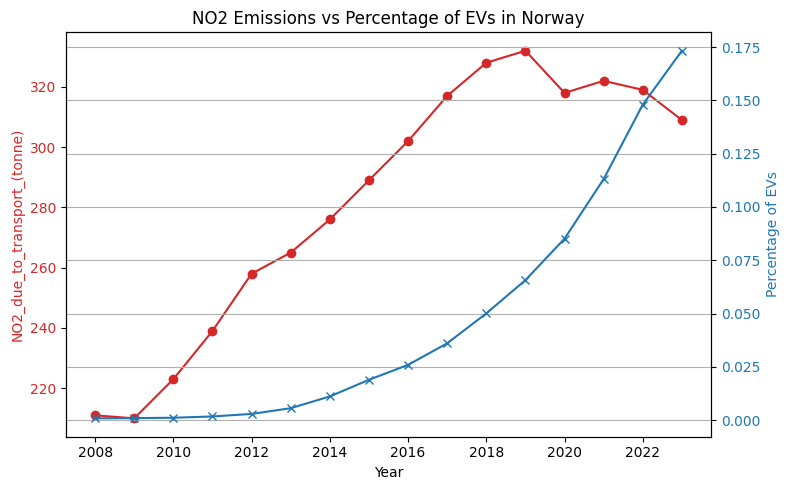

In [48]:
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot CO2 on primary Y-axis
ax1.plot(Norway_data['Year'], Norway_data['N2O_due_to_transport_(tonne)'], color='tab:red', marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('NO2_due_to_transport_(tonne)', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create secondary Y-axis for % of EVs
ax2 = ax1.twinx()
ax2.plot(Norway_data['Year'], Norway_data['Percentage_of_EVs'], color='tab:blue', marker='x')
ax2.set_ylabel('Percentage of EVs', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Title and layout
plt.title('NO2 Emissions vs Percentage of EVs in Norway')
plt.grid(True)
plt.tight_layout()
plt.show()

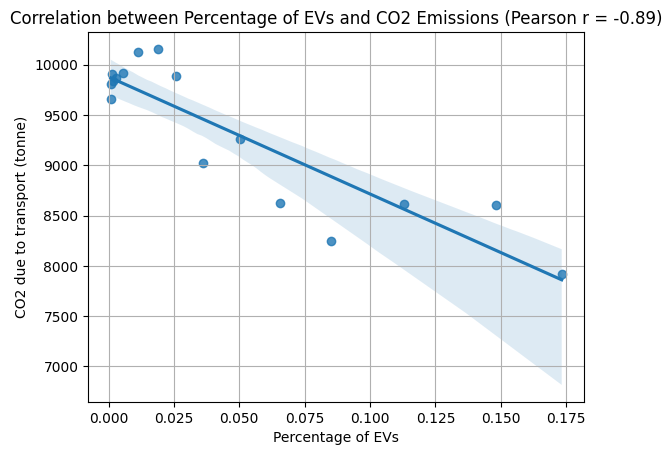

Pearson correlation coefficient: -0.89


In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr # Import pearsonr

# Create a scatter plot with a trendline (regression line)
sns.regplot(x='Percentage_of_EVs', y='CO2_due_to_transport_(tonne)', data=Norway_data)

# Calculate Pearson correlation
corr_coef, p_value = pearsonr(Norway_data['Percentage_of_EVs'], Norway_data['CO2_due_to_transport_(tonne)'])

plt.xlabel('Percentage of EVs')
plt.ylabel('CO2 due to transport (tonne)')
# Add the correlation coefficient to the title
plt.title(f'Correlation between Percentage of EVs and CO2 Emissions (Pearson r = {corr_coef:.2f})')
plt.grid(True)  # Add a grid for better readability
plt.show()

# Print the correlation coefficient
print(f"Pearson correlation coefficient: {corr_coef:.2f}")

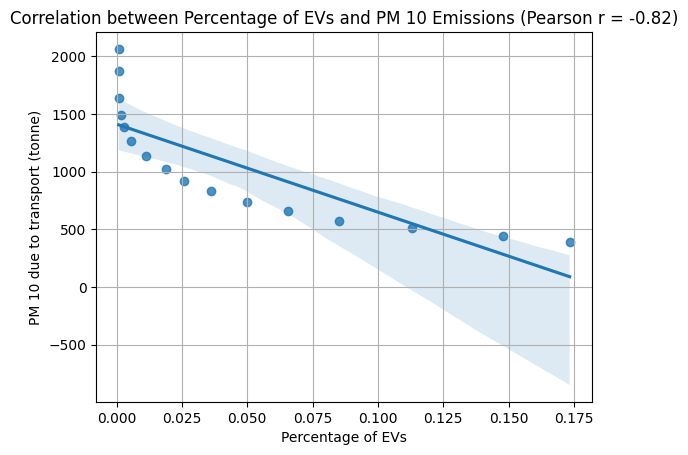

Pearson correlation coefficient: -0.82


In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr # Import pearsonr

# Create a scatter plot with a trendline (regression line)
sns.regplot(x='Percentage_of_EVs', y='PM10_due_to_transport_(tonne)', data=Norway_data)

# Calculate Pearson correlation
corr_coef, p_value = pearsonr(Norway_data['Percentage_of_EVs'], Norway_data['PM10_due_to_transport_(tonne)'])

plt.xlabel('Percentage of EVs')
plt.ylabel('PM 10 due to transport (tonne)')
# Add the correlation coefficient to the title
plt.title(f'Correlation between Percentage of EVs and PM 10 Emissions (Pearson r = {corr_coef:.2f})')
plt.grid(True)  # Add a grid for better readability
plt.show()

# Print the correlation coefficient
print(f"Pearson correlation coefficient: {corr_coef:.2f}")

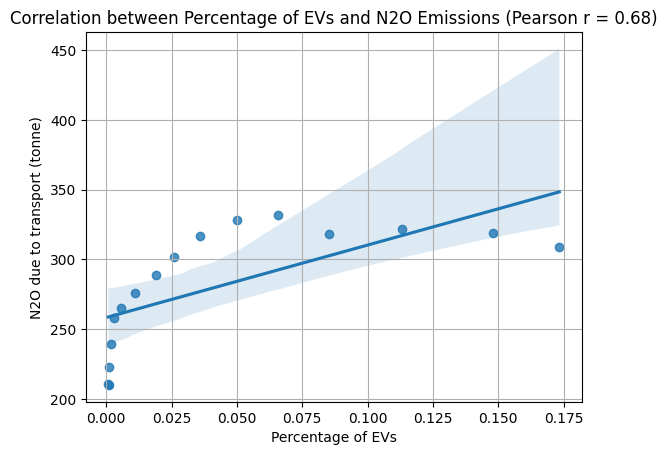

Pearson correlation coefficient: 0.68


In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr # Import pearsonr

# Create a scatter plot with a trendline (regression line)
sns.regplot(x='Percentage_of_EVs', y='N2O_due_to_transport_(tonne)', data=Norway_data)

# Calculate Pearson correlation
corr_coef, p_value = pearsonr(Norway_data['Percentage_of_EVs'], Norway_data['N2O_due_to_transport_(tonne)'])

plt.xlabel('Percentage of EVs')
plt.ylabel('N2O due to transport (tonne)') # Corrected ylabel to match the column name
# Add the correlation coefficient to the title
plt.title(f'Correlation between Percentage of EVs and N2O Emissions (Pearson r = {corr_coef:.2f})')
plt.grid(True)  # Add a grid for better readability
plt.show()

# Print the correlation coefficient
print(f"Pearson correlation coefficient: {corr_coef:.2f}")

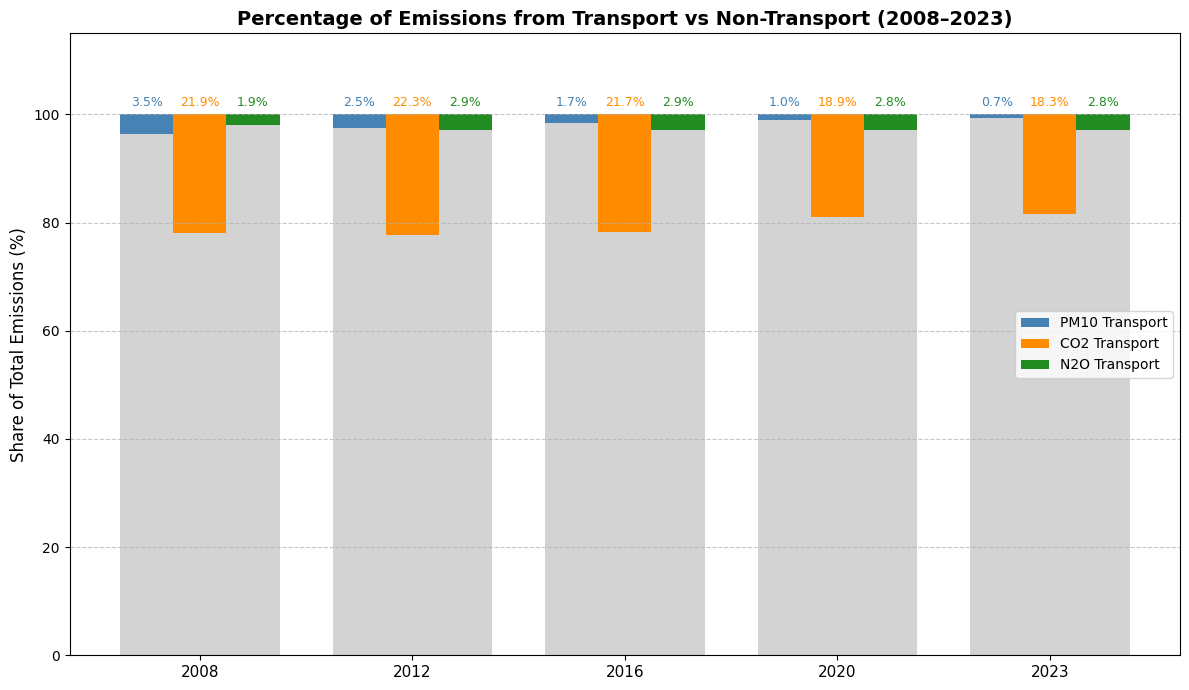

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Data for selected years
data = {
    'Year': [2008, 2012, 2016, 2020, 2023],
    'PM10_due_to_transport_(tonne)': [2064, 1385, 921, 571, 392],
    'PM10_total_(tonne)': [58229, 56015, 55756, 57082, 58662],
    'CO2_due_to_transport_(tonne)': [9807, 9866, 9511, 7967, 7500],
    'CO2_total_(tonne)': [44692, 44258, 43826, 42112, 40898],
    'N2O_due_to_transport_(tonne)': [211, 258, 255, 241, 239],
    'N2O_total_(tonne)': [10983, 8759, 8947, 8523, 8479]
}

# Load into DataFrame
df = pd.DataFrame(data)

# Calculate transport and non-transport percentages
df['PM10_transport'] = df['PM10_due_to_transport_(tonne)'] / df['PM10_total_(tonne)'] * 100
df['CO2_transport'] = df['CO2_due_to_transport_(tonne)'] / df['CO2_total_(tonne)'] * 100
df['N2O_transport'] = df['N2O_due_to_transport_(tonne)'] / df['N2O_total_(tonne)'] * 100

df['PM10_non_transport'] = 100 - df['PM10_transport']
df['CO2_non_transport'] = 100 - df['CO2_transport']
df['N2O_non_transport'] = 100 - df['N2O_transport']

# Plotting
fig, ax = plt.subplots(figsize=(12, 7))
bar_width = 0.25
x = range(len(df['Year']))

# Plot stacked bars
ax.bar([i - bar_width for i in x], df['PM10_non_transport'], width=bar_width, color='lightgrey')
ax.bar([i - bar_width for i in x], df['PM10_transport'], width=bar_width,
       bottom=df['PM10_non_transport'], color='steelblue', label='PM10 Transport')

ax.bar(x, df['CO2_non_transport'], width=bar_width, color='lightgrey')
ax.bar(x, df['CO2_transport'], width=bar_width,
       bottom=df['CO2_non_transport'], color='darkorange', label='CO2 Transport')

ax.bar([i + bar_width for i in x], df['N2O_non_transport'], width=bar_width, color='lightgrey')
ax.bar([i + bar_width for i in x], df['N2O_transport'], width=bar_width,
       bottom=df['N2O_non_transport'], color='forestgreen', label='N2O Transport')

# Customize labels and formatting
ax.set_xticks(x)
ax.set_xticklabels(df['Year'], fontsize=11)
ax.set_ylabel('Share of Total Emissions (%)', fontsize=12)
ax.set_title('Percentage of Emissions from Transport vs Non-Transport (2008–2023)', fontsize=14, weight='bold')
ax.legend(loc='center right', fontsize=10)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add value labels for transport % above each colored bar
for i in x:
    ax.text(i - bar_width, 100 + 1, f"{df['PM10_transport'][i]:.1f}%", ha='center', va='bottom', fontsize=9, color='steelblue')
    ax.text(i, 100 + 1, f"{df['CO2_transport'][i]:.1f}%", ha='center', va='bottom', fontsize=9, color='darkorange')
    ax.text(i + bar_width, 100 + 1, f"{df['N2O_transport'][i]:.1f}%", ha='center', va='bottom', fontsize=9, color='forestgreen')

# Final touches
plt.ylim(0, 115)
plt.tight_layout()
plt.show()

#Ordinary Least Squares (OLS)


In [53]:
import requests
import pandas as pd
import io

url = "https://github.com/Udzf/EV/raw/main/df_data.csv"  # Raw content URL for CSV file
response = requests.get(url)
data = response.content.decode('utf-8')  # Decode content using UTF-8
df_data = pd.read_csv(io.StringIO(data))



In [54]:
import pandas as pd

   # Set display option for floats to show 10 decimal places
pd.set_option('display.float_format', '{:.10f}'.format)

# Merge the DataFrames on 'year'
merged_data2 = pd.merge(filtered_emissions_data2, df_data, on='year', how='left')

In [55]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler # Import MinMaxScaler

# Set display option for floats to show 10 decimal places
pd.set_option('display.float_format', '{:.10f}'.format)

# Merge the DataFrames on 'year'
merged_data2 = pd.merge(filtered_emissions_data2, df_data, on='year', how='left')

# Keep 'year' aside
year_col = merged_data2["year"]

# Select features to scale (exclude 'year')
features_to_scale = merged_data2.drop(columns=["year"])

# Initialize the scaler
scaler = MinMaxScaler() # Use MinMaxScaler for normalization between 0 and 1

# Scale the data to 0–1
scaled_array = scaler.fit_transform(features_to_scale)

# Create a new DataFrame with scaled data
scaled_df = pd.DataFrame(scaled_array, columns=features_to_scale.columns)

# Add back the 'year' column
scaled_df["year"] = year_col.values

# Reassign to merged_data2
merged_data2 = scaled_df
print(merged_data2)


    C02 due to transport (in tonne)  \
0                      0.7419354839   
1                      0.6451612903   
2                      0.6451612903   
3                      0.6774193548   
4                      0.7419354839   
5                      0.7741935484   
6                      0.8064516129   
7                      0.9032258065   
8                      1.0000000000   
9                      0.9354838710   
10                     0.9032258065   
11                     0.8387096774   
12                     0.9032258065   
13                     0.8709677419   
14                     0.8387096774   
15                     0.5806451613   
16                     0.5483870968   
17                     0.4516129032   
18                     0.4516129032   
19                     0.4193548387   
20                     0.0000000000   
21                     0.0645161290   
22                     0.0322580645   

    Emission of N02 due to transport in 1000 tonne  \
0        

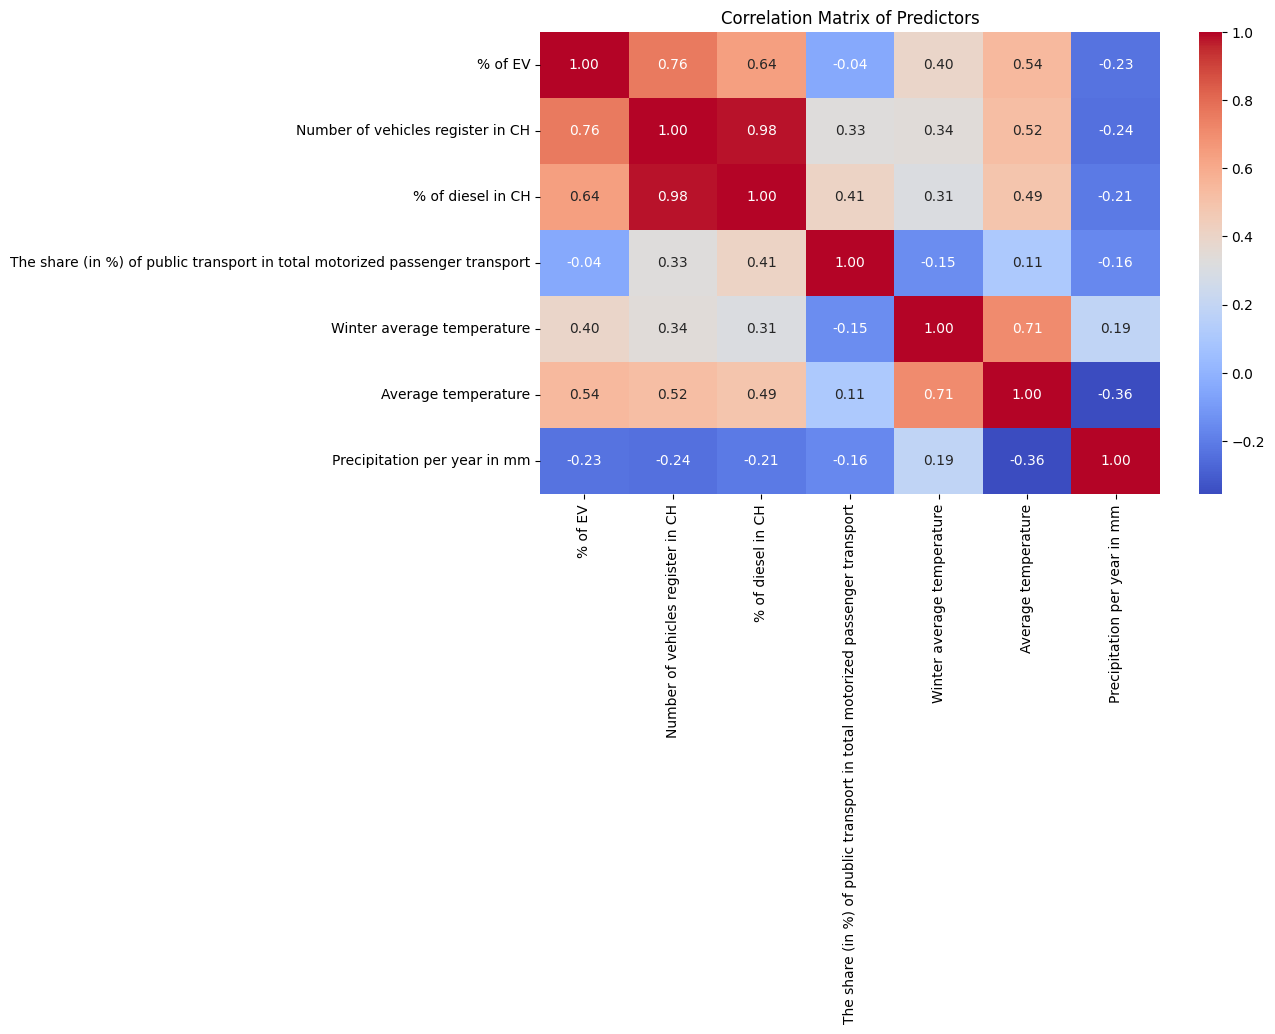

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select only the numeric predictor columns you're using
columns_of_interest = [
    "% of EV","Number of vehicles register in CH", "% of diesel in CH",
    "The share (in %) of public transport in total motorized passenger transport",
    "Winter average temperature", "Average temperature",
    "Precipitation per year in mm"
]

# Create correlation matrix
correlation_matrix = merged_data2[columns_of_interest].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Predictors")
plt.show()

##CO2 - Simple OLS

In [57]:
import statsmodels.formula.api as smf
import pandas as pd

# Assuming you have already loaded and merged your data into merged_data2

# Define the formula for the OLS model
formula = 'Q("C02 due to transport (in tonne)") ~ Q("% of EV")'


# Fit the OLS model
model = smf.ols(formula=formula, data=merged_data2).fit()

# Display results
print(model.summary())

                                     OLS Regression Results                                     
Dep. Variable:     Q("C02 due to transport (in tonne)")   R-squared:                       0.752
Model:                                              OLS   Adj. R-squared:                  0.740
Method:                                   Least Squares   F-statistic:                     63.76
Date:                                  Thu, 15 May 2025   Prob (F-statistic):           8.49e-08
Time:                                          07:20:27   Log-Likelihood:                 12.291
No. Observations:                                    23   AIC:                            -20.58
Df Residuals:                                        21   BIC:                            -18.31
Df Model:                                             1                                         
Covariance Type:                              nonrobust                                         
                   coef    std

##CO2 - Multivariate OLS

In [58]:
import statsmodels.formula.api as smf
import pandas as pd

# Assuming you have already loaded and merged your data into merged_data2

# Define the formula for the OLS model
formula = 'Q("C02 due to transport (in tonne)") ~ Q("% of EV") + Q("The share (in %) of public transport in total motorized passenger transport")'


# Fit the OLS model
model = smf.ols(formula=formula, data=merged_data2).fit()

# Display results
print(model.summary())

                                     OLS Regression Results                                     
Dep. Variable:     Q("C02 due to transport (in tonne)")   R-squared:                       0.850
Model:                                              OLS   Adj. R-squared:                  0.835
Method:                                   Least Squares   F-statistic:                     56.54
Date:                                  Thu, 15 May 2025   Prob (F-statistic):           5.87e-09
Time:                                          07:20:27   Log-Likelihood:                 18.041
No. Observations:                                    23   AIC:                            -30.08
Df Residuals:                                        20   BIC:                            -26.68
Df Model:                                             2                                         
Covariance Type:                              nonrobust                                         
                              

In [59]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm  # ← this is the correct module for add_constant

X = merged_data2[[
    "% of EV","The share (in %) of public transport in total motorized passenger transport"
]]



vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                                             feature          VIF
0                                            % of EV 1.2802894844
1  The share (in %) of public transport in total ... 1.2802894844


##PM 10 - Simple OLS

In [60]:
import statsmodels.formula.api as smf

# Define the formula with Covid Dummy added
formula = 'Q("PM 10 due to transport in tonne") ~ Q("% of EV")'

# Fit the model
model = smf.ols(formula=formula, data=merged_data2).fit()

# Print summary
print(model.summary())

                                     OLS Regression Results                                     
Dep. Variable:     Q("PM 10 due to transport in tonne")   R-squared:                       0.644
Model:                                              OLS   Adj. R-squared:                  0.627
Method:                                   Least Squares   F-statistic:                     37.98
Date:                                  Thu, 15 May 2025   Prob (F-statistic):           4.10e-06
Time:                                          07:20:28   Log-Likelihood:                 9.2926
No. Observations:                                    23   AIC:                            -14.59
Df Residuals:                                        21   BIC:                            -12.31
Df Model:                                             1                                         
Covariance Type:                              nonrobust                                         
                   coef    std

##PM 10 - Multivariate OLS

In [61]:
import statsmodels.formula.api as smf

# Define the formula with Covid Dummy added
formula = 'Q("PM 10 due to transport in tonne") ~ Q("% of EV") + Q("% of diesel in CH") + Q("Covid 19")'

# Fit the model
model = smf.ols(formula=formula, data=merged_data2).fit()

# Print summary
print(model.summary())

                                     OLS Regression Results                                     
Dep. Variable:     Q("PM 10 due to transport in tonne")   R-squared:                       0.962
Model:                                              OLS   Adj. R-squared:                  0.956
Method:                                   Least Squares   F-statistic:                     161.0
Date:                                  Thu, 15 May 2025   Prob (F-statistic):           1.10e-13
Time:                                          07:20:28   Log-Likelihood:                 35.069
No. Observations:                                    23   AIC:                            -62.14
Df Residuals:                                        19   BIC:                            -57.60
Df Model:                                             3                                         
Covariance Type:                              nonrobust                                         
                             c

In [62]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm  # ← this is the correct module for add_constant

X = merged_data2[[
    "% of EV","% of diesel in CH","Covid 19"
]]


vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

             feature          VIF
0            % of EV 2.6426234435
1  % of diesel in CH 2.1878372848
2           Covid 19 1.4818465947


##NO2 - Simple OLS

In [63]:
import statsmodels.formula.api as smf

# Define the formula with Covid Dummy added
formula = 'Q("Emission of N02 due to transport in 1000 tonne") ~ Q("% of EV") '

# Fit the model
model = smf.ols(formula=formula, data=merged_data2).fit()

# Print summary
print(model.summary())

                                             OLS Regression Results                                            
Dep. Variable:     Q("Emission of N02 due to transport in 1000 tonne")   R-squared:                       0.750
Model:                                                             OLS   Adj. R-squared:                  0.738
Method:                                                  Least Squares   F-statistic:                     62.84
Date:                                                 Thu, 15 May 2025   Prob (F-statistic):           9.53e-08
Time:                                                         07:20:29   Log-Likelihood:                 14.468
No. Observations:                                                   23   AIC:                            -24.94
Df Residuals:                                                       21   BIC:                            -22.67
Df Model:                                                            1                                  

##NO2 - Multivariate OLS

In [64]:
import statsmodels.formula.api as smf

# Define the formula with Covid Dummy added
formula = 'Q("Emission of N02 due to transport in 1000 tonne") ~ Q("% of EV") + Q("% of diesel in CH") + Q("Precipitation per year in mm") + Q("Covid 19") '

# Fit the model
model = smf.ols(formula=formula, data=merged_data2).fit()

# Print summary
print(model.summary())

                                             OLS Regression Results                                            
Dep. Variable:     Q("Emission of N02 due to transport in 1000 tonne")   R-squared:                       0.960
Model:                                                             OLS   Adj. R-squared:                  0.951
Method:                                                  Least Squares   F-statistic:                     106.7
Date:                                                 Thu, 15 May 2025   Prob (F-statistic):           2.81e-12
Time:                                                         07:20:29   Log-Likelihood:                 35.431
No. Observations:                                                   23   AIC:                            -60.86
Df Residuals:                                                       18   BIC:                            -55.18
Df Model:                                                            4                                  

In [65]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm  # ← this is the correct module for add_constant

X = merged_data2[[
    "% of EV",
    "% of diesel in CH","Covid 19",
    "Precipitation per year in mm"
]]


vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                        feature          VIF
0                       % of EV 2.8562732426
1             % of diesel in CH 4.0784715997
2                      Covid 19 1.4824558449
3  Precipitation per year in mm 2.1845696624


# Prediction

## Prediction for CO2


### Prediction for CO2 with simple linear regression


In [66]:
from sklearn.model_selection import train_test_split

In [67]:
X = merged_data2[['% of EV']]
y = merged_data2['C02 due to transport (in tonne)']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

In [69]:
from sklearn.linear_model import LinearRegression

In [70]:
# There are three steps to model something with sklearn
# 1. Set up the model
model = LinearRegression(fit_intercept= True)
# 2. Use fit
model.fit(X_train, y_train)
# 3. Check the score/accuracy


LinearRegression()

In [71]:
#Model prediction from X_test
predictions = model.predict(X_test)

In [72]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [73]:
# Compute the MAE, the MSE and the R^2
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)



In [74]:
predictions_train = model.predict(X_train)
mae_train = mean_absolute_error(y_train, predictions_train)
mse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)

print(f"MAE test set: {mae:0.2f}; MAE train set: {mae_train:0.2f};")
print(f"MSE test set: {mse:0.2f}; MSE train set: {mse_train:0.2f};")
print(f"R\u00b2 test set: {r2:0.2f}; R\u00b2 train set: {r2_train:0.2f};" )

MAE test set: 0.19; MAE train set: 0.11;
MSE test set: 0.05; MSE train set: 0.01;
R² test set: 0.72; R² train set: 0.72;


### Prediction for CO2 with Multivariate linear regression


In [75]:
from sklearn.model_selection import train_test_split

In [76]:
X = merged_data2[['% of EV','The share (in %) of public transport in total motorized passenger transport']]
y = merged_data2[['C02 due to transport (in tonne)']]

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

In [78]:
from sklearn.preprocessing import MinMaxScaler

In [79]:
# 1. Set up the model
model = LinearRegression()
# 2. Use fit
model.fit(X_train, y_train)
# 3. Check the score/accuracy
print("R\u00b2 Score of the model: ", round(model.score(X_train, y_train), 3))
# 4. Print the coefficients of the linear model
print("Intercept: ", model.intercept_[0])
model_coeff = pd.DataFrame(model.coef_.flatten(),
                     index=['% of EV','The share (in %) of public transport in total motorized passenger transport'],
                     columns=['Coefficients multivariate model'])
model_coeff # Get the coefficients, w

R² Score of the model:  0.775
Intercept:  0.6509419169931784


,Coefficients multivariate model
% of EV,-0.9375948686
The share (in %) of public transport in total motorized passenger transport,0.1946520409


In [80]:
# Predict:
predictions = model.predict(X_test)

# Compute the MAE, the MSE and the R^2 on the test set
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Compute the MAE, the MSE and the R^2 on the training set
predictions_train = model.predict(X_train)
mae_train = mean_absolute_error(y_train, predictions_train)
mse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)

print(f"MAE test set: {mae:0.2f}; MAE training set: {mae_train:0.2f};")
print(f"MSE test set: {mse:0.2f}; MSE training set: {mse_train:0.2f};")
print(f"R\u00b2 test set: {r2:0.2f}; R\u00b2 training set: {r2_train:0.2f};" )

MAE test set: 0.10; MAE training set: 0.09;
MSE test set: 0.02; MSE training set: 0.01;
R² test set: 0.90; R² training set: 0.77;


### Polynomial regression

In [81]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Prepare the data
X = merged_data2[['% of EV']]
y = merged_data2['C02 due to transport (in tonne)']

# Step 2: Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Step 3: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=0)

# Step 4: Train the model
poly_model = LinearRegression()
poly_model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred_test = poly_model.predict(X_test)
y_pred_train = poly_model.predict(X_train)

mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print(f"MAE test: {mae_test:.2f}, train: {mae_train:.2f}")
print(f"MSE test: {mse_test:.2f}, train: {mse_train:.2f}")
print(f"R² test: {r2_test:.3f}, train: {r2_train:.3f}")

MAE test: 0.14, train: 0.09
MSE test: 0.03, train: 0.01
R² test: 0.846, train: 0.780


### Polynomial regression with multivariable

In [82]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Step 1: Define your features and target
X = merged_data2[[
    '% of EV','The share (in %) of public transport in total motorized passenger transport'
]]
y = merged_data2['C02 due to transport (in tonne)']

# Step 2: Generate polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=0)

# Step 4: Train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Predict and evaluate
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Step 6: Print results
print(f"MAE test set: {mae_test:.2f}, MAE train set: {mae_train:.2f}")
print(f"MSE test set: {mse_test:.2f}, MSE train set: {mse_train:.2f}")
print(f"R² test set: {r2_test:.3f}, R² train set: {r2_train:.3f}")

MAE test set: 0.37, MAE train set: 0.05
MSE test set: 0.27, MSE train set: 0.00
R² test set: -0.650, R² train set: 0.924


### Lazypredict

In [83]:
pip install lazypredict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.2/700.2 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.3 MB/s eta 0:00:00


In [84]:
X = merged_data2[['% of EV']]
y = merged_data2[['C02 due to transport (in tonne)']]

In [85]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

# Define your features (X) and target (y)
X = merged_data2[[
    '% of EV'
]]
y = merged_data2['C02 due to transport (in tonne)']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and run lazypredict
reg = LazyRegressor(verbose=0, ignore_warnings=True)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
# Filter out LightGBM from the results
models_filtered = models[~models.index.str.contains("LightGBM", case=False)]
import matplotlib.pyplot as plt



  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 18, number of used features: 0
[LightGBM] [Info] Start training from score 0.614695
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

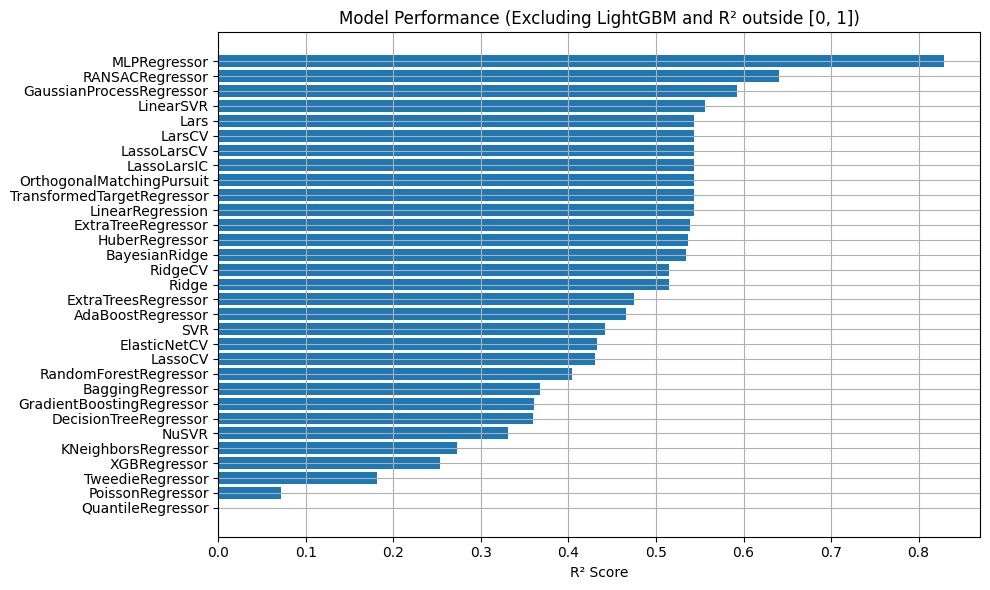

In [87]:
# Remove LightGBM from model results
models_filtered = models[~models.index.str.contains("LightGBM", case=False)]

# Filter models with R-Squared between 0 and 1
models_filtered_r_squared = models_filtered[(models_filtered['R-Squared'] >= 0) & (models_filtered['R-Squared'] <= 1)]

# Plot filtered data
import matplotlib.pyplot as plt

models_sorted = models_filtered_r_squared.sort_values(by="R-Squared", ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(models_sorted.index, models_sorted['R-Squared'])
plt.xlabel("R² Score")
plt.title("Model Performance (Excluding LightGBM and R² outside [0, 1])")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

In [88]:
print(models_filtered.sort_values(by="R-Squared", ascending=False).head(20))

                            Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                      
MLPRegressor                              0.77       0.83  0.09        0.16
RANSACRegressor                           0.52       0.64  0.12        0.08
GaussianProcessRegressor                  0.46       0.59  0.13        0.07
LinearSVR                                 0.41       0.56  0.14        0.05
Lars                                      0.39       0.54  0.14        0.05
LarsCV                                    0.39       0.54  0.14        0.07
LassoLarsCV                               0.39       0.54  0.14        0.04
LassoLarsIC                               0.39       0.54  0.14        0.07
OrthogonalMatchingPursuit                 0.39       0.54  0.14        0.07
TransformedTargetRegressor                0.39       0.54  0.14        0.03
LinearRegression                          0.39       0.54  0.14        0.09
ExtraTreeReg

### Lazypredict with multivariable

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 16, number of used features: 0
[LightGBM] [Info] Start training from score 0.594758
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

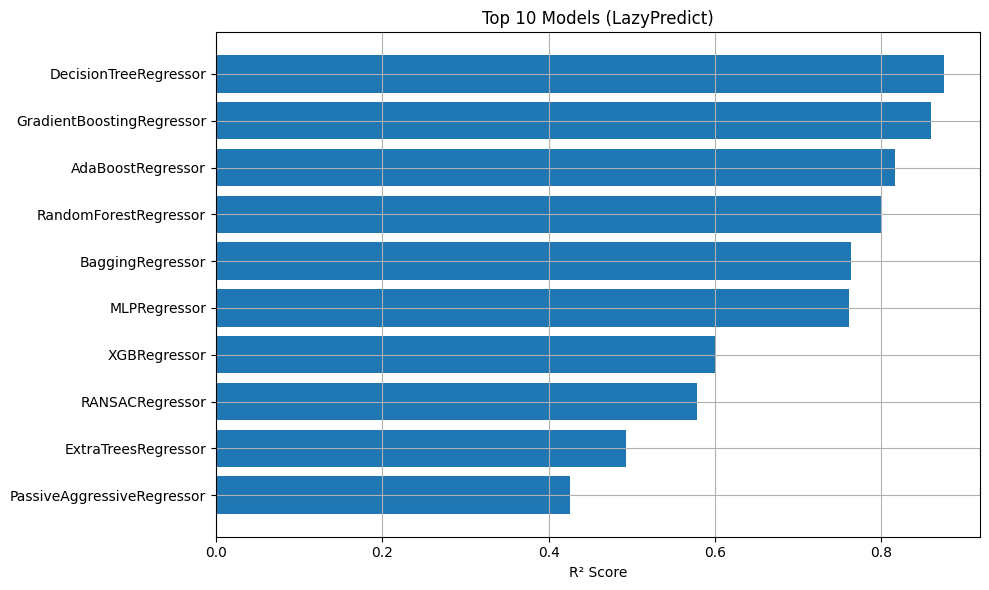

In [89]:
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prepare your data
X = merged_data2[[
    '% of EV','The share (in %) of public transport in total motorized passenger transport'
]]
y = merged_data2['C02 due to transport (in tonne)']

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data properly (important!)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Run LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=True)
models, _ = reg.fit(X_train, X_test, y_train, y_test)

# Drop LightGBM and NaNs safely
models = models[~models.index.astype(str).str.contains("LightGBM", case=False)]
models = models.dropna()

# Show and plot top 10 models
print(models.sort_values("R-Squared", ascending=False).head(10))

models_sorted = models.sort_values(by="R-Squared", ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(models_sorted.index[:10], models_sorted["R-Squared"][:10])
plt.xlabel("R² Score")
plt.title("Top 10 Models (LazyPredict)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


## Prediction for NO2


### Prediction for NO2 with simple linear regression


In [90]:
X = merged_data2[['% of EV']]
y = merged_data2['Emission of N02 due to transport in 1000 tonne']

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

In [92]:
from sklearn.linear_model import LinearRegression

In [93]:
# There are three steps to model something with sklearn
# 1. Set up the model
model = LinearRegression(fit_intercept= True)
# 2. Use fit
model.fit(X_train, y_train)
# 3. Check the score/accuracy


LinearRegression()

In [94]:
#Model prediction from X_test
predictions = model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

predictions_train = model.predict(X_train)
mae_train = mean_absolute_error(y_train, predictions_train)
mse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)

print(f"MAE test set: {mae:0.2f}; MAE train set: {mae_train:0.2f};")
print(f"MSE test set: {mse:0.2f}; MSE train set: {mse_train:0.2f};")
print(f"R\u00b2 test set: {r2:0.2f}; R\u00b2 train set: {r2_train:0.2f};" )

MAE test set: 0.10; MAE train set: 0.10;
MSE test set: 0.02; MSE train set: 0.02;
R² test set: 0.90; R² train set: 0.70;


### Prediction for NO2 with Multivariate linear regression


In [95]:
X = merged_data2[['% of EV','% of diesel in CH','Covid 19','Precipitation per year in mm']]
y = merged_data2[['Emission of N02 due to transport in 1000 tonne']]

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

In [97]:
# 1. Set up the model
model = LinearRegression()
# 2. Use fit
model.fit(X_train, y_train)
# 3. Check the score/accuracy
print("R\u00b2 Score of the model: ", round(model.score(X_train, y_train), 3))
# 4. Print the coefficients of the linear model
print("Intercept: ", model.intercept_[0])
model_coeff = pd.DataFrame(model.coef_.flatten(),
                     index=['% of EV','% of diesel in CH','Covid 19','Precipitation per year in mm'],
                     columns=['Coefficients multivariate model'])
model_coeff # Get the coefficients, w

R² Score of the model:  0.941
Intercept:  0.8027243107459207


,Coefficients multivariate model
% of EV,-0.43
% of diesel in CH,-0.37
Covid 19,0.00
Precipitation per year in mm,0.08


In [98]:
# Predict:
predictions = model.predict(X_test)

# Compute the MAE, the MSE and the R^2 on the test set
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Compute the MAE, the MSE and the R^2 on the training set
predictions_train = model.predict(X_train)
mae_train = mean_absolute_error(y_train, predictions_train)
mse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)

print(f"MAE test set: {mae:0.2f}; MAE training set: {mae_train:0.2f};")
print(f"MSE test set: {mse:0.2f}; MSE training set: {mse_train:0.2f};")
print(f"R\u00b2 test set: {r2:0.2f}; R\u00b2 training set: {r2_train:0.2f};" )

MAE test set: 0.12; MAE training set: 0.04;
MSE test set: 0.02; MSE training set: 0.00;
R² test set: 0.71; R² training set: 0.94;


### Polynomial regression

In [99]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Prepare the data
X = merged_data2[['% of EV']]
y = merged_data2['Emission of N02 due to transport in 1000 tonne']

# Step 2: Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Step 3: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=0)

# Step 4: Train the model
poly_model = LinearRegression()
poly_model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred_test = poly_model.predict(X_test)
y_pred_train = poly_model.predict(X_train)

mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print(f"MAE test: {mae_test:.2f}, train: {mae_train:.2f}")
print(f"MSE test: {mse_test:.2f}, train: {mse_train:.2f}")
print(f"R² test: {r2_test:.3f}, train: {r2_train:.3f}")

MAE test: 0.08, train: 0.07
MSE test: 0.01, train: 0.01
R² test: 0.863, train: 0.833


### Polynomial regression with multivariable

In [100]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Prepare the data
X = merged_data2[['% of EV','% of diesel in CH','Precipitation per year in mm','Covid 19']]
y = merged_data2['Emission of N02 due to transport in 1000 tonne']

# Step 2: Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Step 3: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=0)

# Step 4: Train the model
poly_model = LinearRegression()
poly_model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred_test = poly_model.predict(X_test)
y_pred_train = poly_model.predict(X_train)

mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print(f"MAE test: {mae_test:.2f}, train: {mae_train:.2f}")
print(f"MSE test: {mse_test:.2f}, train: {mse_train:.2f}")
print(f"R² test: {r2_test:.3f}, train: {r2_train:.3f}")

MAE test: 0.05, train: 0.02
MSE test: 0.00, train: 0.00
R² test: 0.950, train: 0.989


### Lazypredict

In [101]:
X = merged_data2[['% of EV']]
y = merged_data2[['Emission of N02 due to transport in 1000 tonne']]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [102]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

# Define your features (X) and target (y)
X = merged_data2[[
    '% of EV'
]]
y = merged_data2['Emission of N02 due to transport in 1000 tonne']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and run lazypredict
reg = LazyRegressor(verbose=0, ignore_warnings=True)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
# Filter out LightGBM from the results
models_filtered = models[~models.index.str.contains("LightGBM", case=False)]
import matplotlib.pyplot as plt

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 18, number of used features: 0
[LightGBM] [Info] Start training from score 0.515056
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

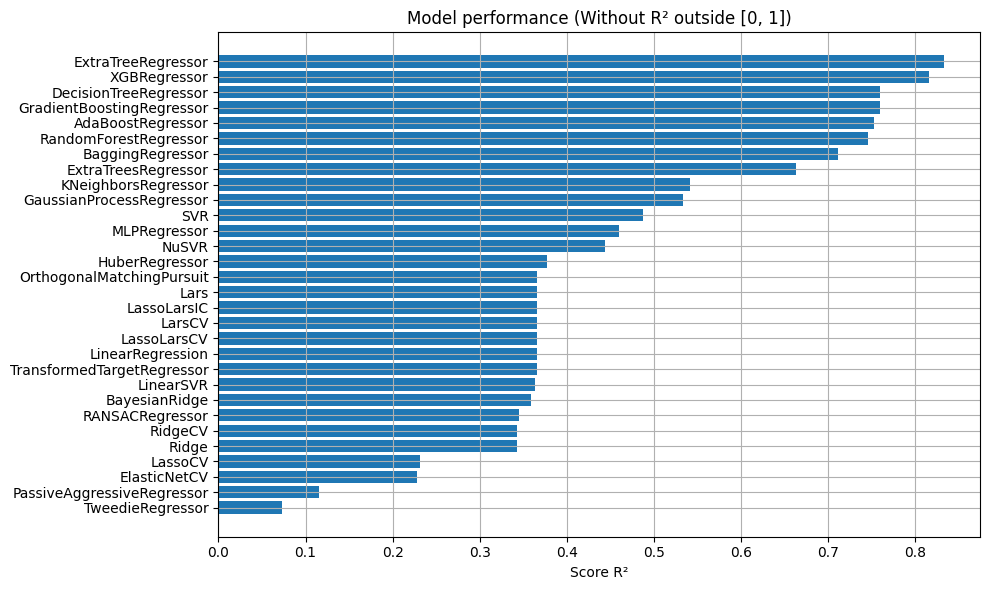

In [103]:
# Remove LightGBM from model results
models_filtered = models[~models.index.str.contains("LightGBM", case=False)]

# Filtrer les modèles dont le R-Squared est entre 0 et 1
models_filtered_r_squared = models_filtered[(models_filtered['R-Squared'] >= 0) & (models_filtered['R-Squared'] <= 1)]

# Tracer les données filtrées
import matplotlib.pyplot as plt

models_sorted = models_filtered_r_squared.sort_values(by="R-Squared", ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(models_sorted.index, models_sorted['R-Squared'])
plt.xlabel("Score R²")
plt.title("Model performance (Without R² outside [0, 1])")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

In [104]:
print(models_filtered.sort_values(by="R-Squared", ascending=False).head(10))

                           Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                     
ExtraTreeRegressor                       0.78       0.83  0.08        0.02
XGBRegressor                             0.76       0.82  0.09        0.33
DecisionTreeRegressor                    0.68       0.76  0.10        0.02
GradientBoostingRegressor                0.68       0.76  0.10        0.11
AdaBoostRegressor                        0.67       0.75  0.10        0.13
RandomForestRegressor                    0.66       0.75  0.10        0.36
BaggingRegressor                         0.61       0.71  0.11        0.05
ExtraTreesRegressor                      0.55       0.66  0.12        0.11
KNeighborsRegressor                      0.39       0.54  0.14        0.04
GaussianProcessRegressor                 0.38       0.53  0.14        0.01


### Lazypredict with multivariable

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 16, number of used features: 0
[LightGBM] [Info] Start training from score 0.487877
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

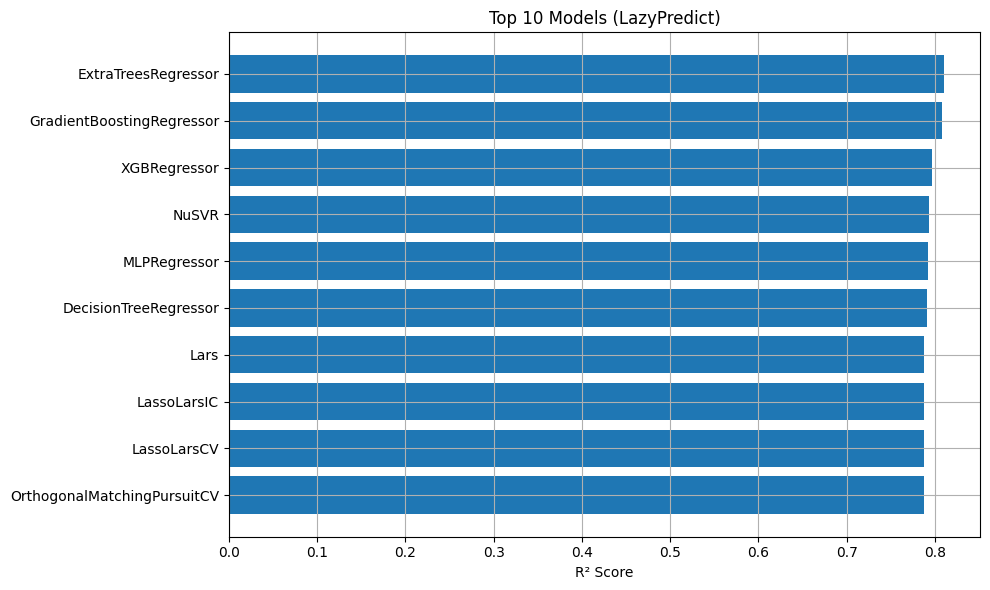

In [105]:
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prepare your data
X = merged_data2[[
    '% of EV','% of diesel in CH','Precipitation per year in mm','Covid 19'
]]
y = merged_data2['Emission of N02 due to transport in 1000 tonne']

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data properly (important!)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Run LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=True)
models, _ = reg.fit(X_train, X_test, y_train, y_test)

# Drop LightGBM and NaNs safely
models = models[~models.index.astype(str).str.contains("LightGBM", case=False)]
models = models.dropna()

# Show and plot top 10 models
print(models.sort_values("R-Squared", ascending=False).head(10))

models_sorted = models.sort_values(by="R-Squared", ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(models_sorted.index[:10], models_sorted["R-Squared"][:10])
plt.xlabel("R² Score")
plt.title("Top 10 Models (LazyPredict)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

## Prediction for PM 10

### Prediction for PM 10 with simple linear regression

In [106]:
X = merged_data2[['% of EV']]
y = merged_data2['PM 10 due to transport in tonne']

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

In [108]:
# There are three steps to model something with sklearn
# 1. Set up the model
model = LinearRegression(fit_intercept= True)
# 2. Use fit
model.fit(X_train, y_train)
# 3. Check the score/accuracy


LinearRegression()

In [109]:
#Model prediction from X_test
predictions = model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

predictions_train = model.predict(X_train)
mae_train = mean_absolute_error(y_train, predictions_train)
mse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)

print(f"MAE test set: {mae:0.2f}; MAE train set: {mae_train:0.2f};")
print(f"MSE test set: {mse:0.2f}; MSE train set: {mse_train:0.2f};")
print(f"R\u00b2 test set: {r2:0.2f}; R\u00b2 train set: {r2_train:0.2f};" )

MAE test set: 0.12; MAE train set: 0.14;
MSE test set: 0.02; MSE train set: 0.03;
R² test set: 0.71; R² train set: 0.57;


### Prediction for PM 10 with Multivariate linear regression

In [110]:
y = merged_data2[['PM 10 due to transport in tonne']]
X = merged_data2[['% of EV', '% of diesel in CH','Covid 19']]

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

In [112]:
# 1. Set up the model
model = LinearRegression()
# 2. Use fit
model.fit(X_train, y_train)
# 3. Check the score/accuracy
print("R\u00b2 Score of the model: ", round(model.score(X_train, y_train), 3))
# 4. Print the coefficients of the linear model
print("Intercept: ", model.intercept_[0])
model_coeff = pd.DataFrame(model.coef_.flatten(),
                     index=['% of EV','% of diesel in CH','Covid 19'],
                     columns=['Coefficients multivariate model'])
model_coeff # Get the coefficients, w

R² Score of the model:  0.949
Intercept:  0.9231691131300552


,Coefficients multivariate model
% of EV,-0.30
% of diesel in CH,-0.51
Covid 19,0.00


In [113]:
# Predict:
predictions = model.predict(X_test)

# Compute the MAE, the MSE and the R^2 on the test set
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Compute the MAE, the MSE and the R^2 on the training set
predictions_train = model.predict(X_train)
mae_train = mean_absolute_error(y_train, predictions_train)
mse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)

print(f"MAE test set: {mae:0.2f}; MAE training set: {mae_train:0.2f};")
print(f"MSE test set: {mse:0.2f}; MSE training set: {mse_train:0.2f};")
print(f"R\u00b2 test set: {r2:0.2f}; R\u00b2 training set: {r2_train:0.2f};" )

MAE test set: 0.09; MAE training set: 0.05;
MSE test set: 0.02; MSE training set: 0.00;
R² test set: 0.73; R² training set: 0.95;


### Polynomial regression

In [114]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Prepare the data
X = merged_data2[['% of EV']]
y = merged_data2['PM 10 due to transport in tonne']

# Step 2: Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Step 3: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=0)

# Step 4: Train the model
poly_model = LinearRegression()
poly_model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred_test = poly_model.predict(X_test)
y_pred_train = poly_model.predict(X_train)

mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print(f"MAE test: {mae_test:.2f}, train: {mae_train:.2f}")
print(f"MSE test: {mse_test:.2f}, train: {mse_train:.2f}")
print(f"R² test: {r2_test:.3f}, train: {r2_train:.3f}")

MAE test: 0.09, train: 0.06
MSE test: 0.01, train: 0.01
R² test: 0.863, train: 0.880


### Polynomial regression with multivariable

In [115]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Prepare the data
X = merged_data2[['% of EV','% of diesel in CH','Covid 19']]
y = merged_data2['PM 10 due to transport in tonne']

# Step 2: Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Step 3: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=0)

# Step 4: Train the model
poly_model = LinearRegression()
poly_model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred_test = poly_model.predict(X_test)
y_pred_train = poly_model.predict(X_train)

mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print(f"MAE test: {mae_test:.2f}, train: {mae_train:.2f}")
print(f"MSE test: {mse_test:.2f}, train: {mse_train:.2f}")
print(f"R² test: {r2_test:.3f}, train: {r2_train:.3f}")

MAE test: 0.05, train: 0.04
MSE test: 0.01, train: 0.00
R² test: 0.917, train: 0.960


### Lazypredict

In [116]:
X = merged_data2[['% of EV']]
y = merged_data2[['PM 10 due to transport in tonne']]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [117]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

# Define your features (X) and target (y)
X = merged_data2[[
    '% of EV'
]]
y = merged_data2['PM 10 due to transport in tonne']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and run lazypredict
reg = LazyRegressor(verbose=0, ignore_warnings=True)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
# Filter out LightGBM from the results
models_filtered = models[~models.index.str.contains("LightGBM", case=False)]
import matplotlib.pyplot as plt

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 18, number of used features: 0
[LightGBM] [Info] Start training from score 0.541104
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

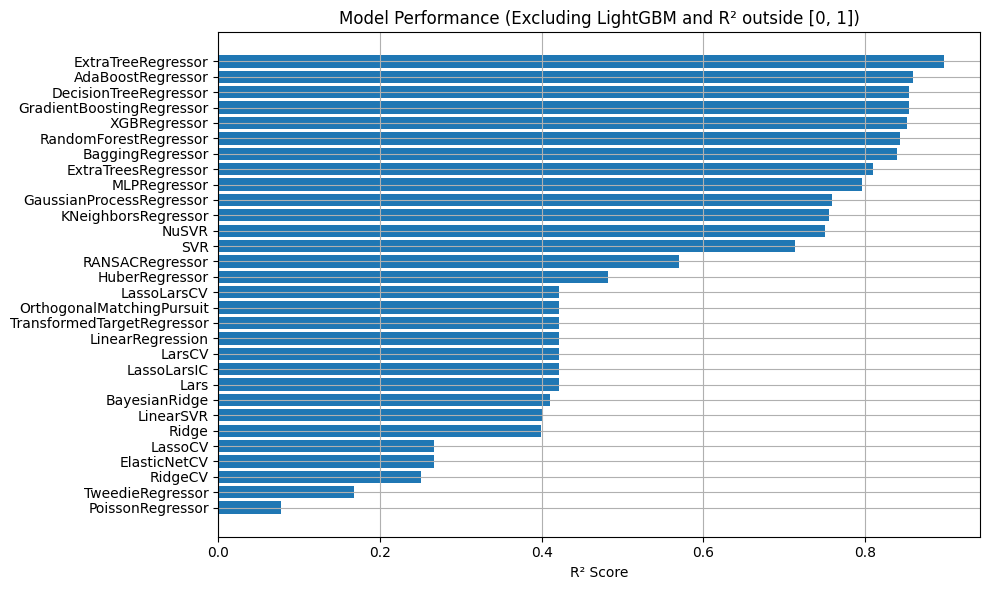

In [118]:
# Remove LightGBM from model results
models_filtered = models[~models.index.str.contains("LightGBM", case=False)]

# Filter models with R-Squared between 0 and 1
models_filtered_r_squared = models_filtered[(models_filtered['R-Squared'] >= 0) & (models_filtered['R-Squared'] <= 1)]

# Plot filtered data
import matplotlib.pyplot as plt

models_sorted = models_filtered_r_squared.sort_values(by="R-Squared", ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(models_sorted.index, models_sorted['R-Squared'])
plt.xlabel("R² Score")
plt.title("Model Performance (Excluding LightGBM and R² outside [0, 1])")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

In [119]:
print(models_filtered.sort_values(by="R-Squared", ascending=False).head(10))

                           Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                     
ExtraTreeRegressor                       0.86       0.90  0.08        0.12
AdaBoostRegressor                        0.81       0.86  0.09        0.32
DecisionTreeRegressor                    0.81       0.85  0.09        0.05
GradientBoostingRegressor                0.81       0.85  0.09        0.42
XGBRegressor                             0.80       0.85  0.09        0.14
RandomForestRegressor                    0.79       0.84  0.10        0.37
BaggingRegressor                         0.79       0.84  0.10        0.14
ExtraTreesRegressor                      0.75       0.81  0.11        0.45
MLPRegressor                             0.73       0.80  0.11        0.11
GaussianProcessRegressor                 0.68       0.76  0.12        0.06


### Lazypredict with multivariable

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 16, number of used features: 0
[LightGBM] [Info] Start training from score 0.487877
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

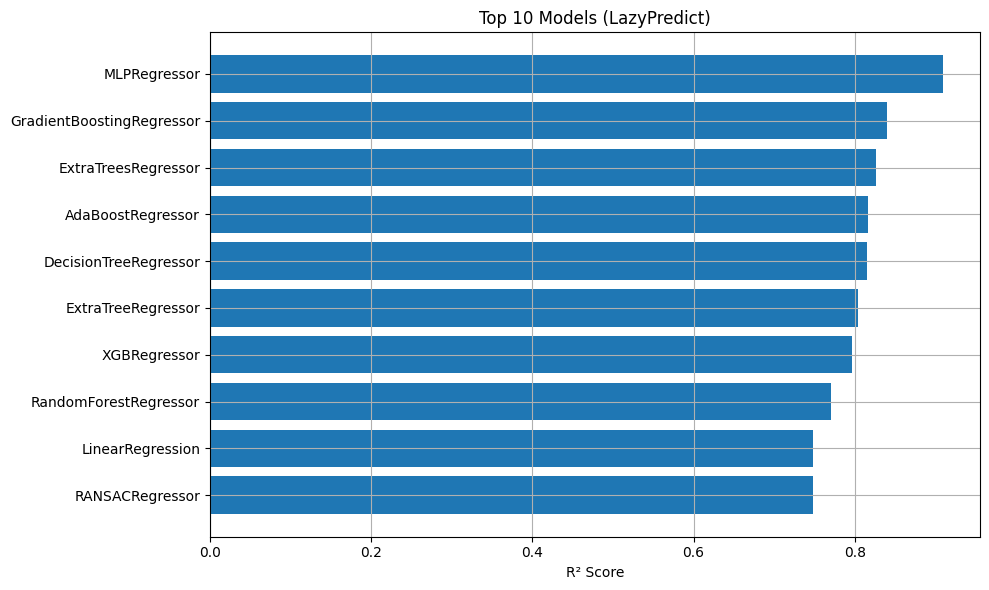

In [120]:
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prepare your data
X = merged_data2[[
    '% of EV','% of diesel in CH','Covid 19'
]]
y = merged_data2['Emission of N02 due to transport in 1000 tonne']

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data properly (important!)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Run LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=True)
models, _ = reg.fit(X_train, X_test, y_train, y_test)

# Drop LightGBM and NaNs safely
models = models[~models.index.astype(str).str.contains("LightGBM", case=False)]
models = models.dropna()

# Show and plot top 10 models
print(models.sort_values("R-Squared", ascending=False).head(10))

models_sorted = models.sort_values(by="R-Squared", ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(models_sorted.index[:10], models_sorted["R-Squared"][:10])
plt.xlabel("R² Score")
plt.title("Top 10 Models (LazyPredict)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()